# InstaCart Online Grocery Basket Analysis Dataset

## Project Link: https://github.com/boratonAJ/InstacartApp/tree/main

# 1. Introduction

Instacart is a grocery shopping app and same-day delivery service.

The Instacart purchasing process works as follows:

1. It begins with a user placing an order through the app.
2. Then, a shopper is notified of the order via the app, purchases the requested items at a store, and delivers them to the user.

The application's database has been extracted by Kaggle and is available at the following link:
https://www.kaggle.com/datasets/yasserh/instacart-online-grocery-basket-analysis-dataset

The dataset describes orders from (anonymous) customers over time, totaling over 3 million orders.  It includes the following tables: Orders, products, aisles, departments, and order_products (we are only working with the prior order data).

### 1.2. Problem Statement (Persona-Driven)

- Persona — Emma, Product & Ops Lead 
    - Role: Head of Product Operations at a grocery retailer using Instacart data to improve retention and operations.  
    - Goal: Reduce time-to-next-order, improve reorder rates, and optimize staffing/fulfillment by understanding customer ordering behavior and product co-purchases.  
    - Key question: Which customers and products drive repeat business, when do customers order, and which product bundles can increase basket size via cross-sell?

- Persona — Mateo, Data Scientist 
    - Role: Responsible for turning data into features, models and dashboards that answer business questions.  
    - Goal: Build robust predictive models for days-until-next-order and reorder probability; produce explainable features and a reproducible pipeline.  
    - Key question: Which signals (user-level, product-level, sequence embeddings, time features) best predict reorder behavior and days-to-next-order?

- Persona — Priya, Marketing Analyst  
    - Role: Designs campaigns and promotions to encourage reorders.  
    - Goal: Identify high-value segments and complementary product bundles for targeted promotions.  
    - Key question: Which segments (light/medium/heavy) respond best to cross-sell, and which product pairs yield highest lift?

### 1.3. High-level Problem Statement

We use the historical Instacart order data to:
- (1) describe and visualize buying patterns (counts, timing, basket size, reorder rates, co-purchases), 
- (2) segment customers by behavior, and 
- (3) build predictive models to 
    - (a) estimate days until a customer’s next order and 
    - (b) predict reorder likelihood and expected basket size. Deliver interactive dashboards, reproducible notebooks, and a lightweight demo API.

### 1.4. Primary Objectives

The following are the objectives of this project
- Provide exploratory insights: total users/products, top items, reorder stats, timing, co-purchases, and customer activity distribution.
- Create customer segments (Light/Medium/Heavy) and characterize reorder behaviors.
- Build predictive models:
  - Predict days_until_next_order (regression).
  - Predict reorder probability for a product (binary classification).
  - Predict expected basket size for the next order (regression).
- Deliverables: 
    - reproducible notebook(s) (Final_Instacart_notebook.ipynb), 
    - SQL snippets & views, and 
    - a dashboard (notebook visual dashboard + optional Flask demo), 
    - and model artifacts.

# 2. Data Extraction and Processing

### 2.1. Importing the necessary libraries:

In [6]:
# Load libraries
import os
import subprocess
import sys
import zipfile
import kagglehub # !pip install kagglehub
import shutil
import glob
from logging import root
import psycopg2 # !pip install psycopg2-binary
from logging import root
from isort import file
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import math
import scipy.stats as stats
# Import required modules
import requests
from PIL import Image as PILImage # !pip install Pillow
from io import BytesIO

In [7]:
# install required packages
%pip install pandas numpy matplotlib seaborn scipy statsmodels scikit-learn duckdb IPython psycopg2-binary Pillow

Note: you may need to restart the kernel to use updated packages.


## Architecture - Instacart Modeling Pipeline

The diagram below summarizes the high-level architecture used by the notebooks: data ingestion, preprocessing, feature engineering, modeling and serving. Run the code cell below to render the diagram inline.

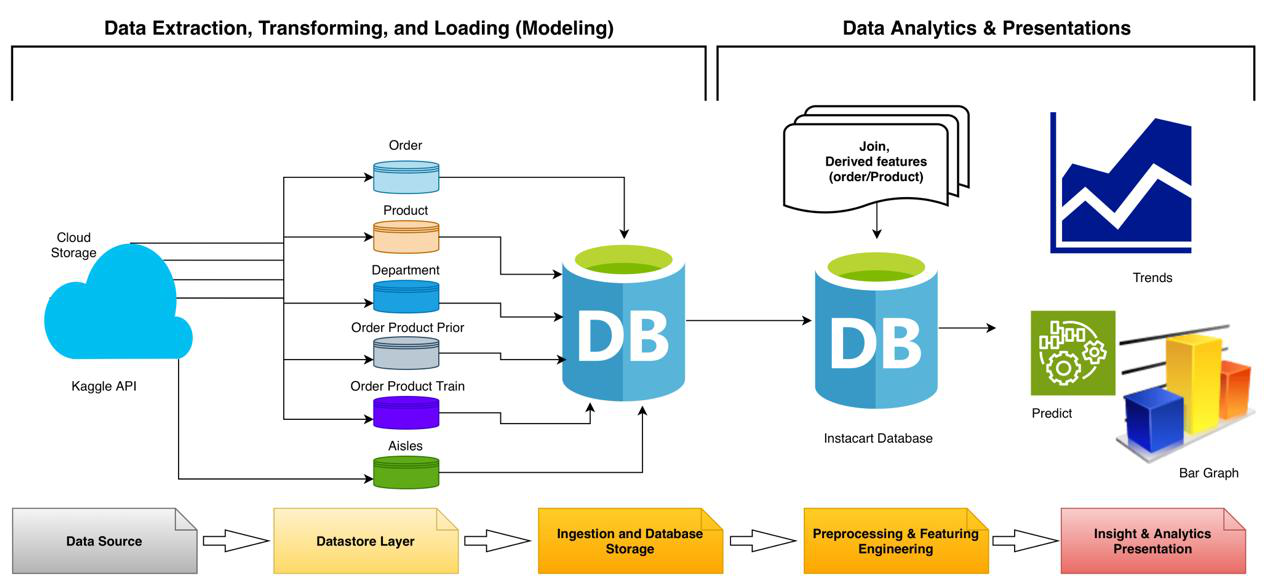

In [8]:
# Display the Architecture diagram image inline in the notebook
# URL to the image file on GitHub
img_path = "https://raw.githubusercontent.com/boratonAJ/InstacartApp/main/notebook/images/final_draw.drawio_3.jpeg"

try:
    # Fetch the image from the URL
    response = requests.get(img_path)
    response.raise_for_status()  # Raise an error for bad responses (4xx or 5xx)
    img_arc = PILImage.open(BytesIO(response.content))
    
    # Display the image
    display(img_arc)
except Exception as e:
    print(f"Failed to load image from {img_path}.\nError: {e}")

### 2.2. Install all the Kaggle Package for downloading the dataset

In [9]:
# Download latest version
%pip install kagglehub # Install the kagglehub package to interact with Kaggle datasets and downloads 

Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [11]:
!pwd

/Users/boratonaj/Documents/GWU_Study_Course/Data Management for Analytics_DNSC_6305_81/final_project/InstacartApp/notebook


### 2.3. Dowload the raw CSV files from Kaggle

In [12]:
# Download the data from Kaggle and move CSV files to destination folder
def downloadData(dest_folder, kaggle_path=None):
    """
    Download dataset using kagglehub (if kaggle_path provided) or use existing global `path`,
    then move CSV files (or extract zip) into dest_folder and clean up.
    """

    # determine download path
    if kaggle_path:
        """Download dataset from Kaggle using kagglehub."""
        download_path = kagglehub.dataset_download(kaggle_path)
        print("Path to dataset files:", download_path)
    else:
        download_path = globals().get("path") # use existing global path
        if not download_path:
            raise ValueError("No kaggle_path provided and no global 'path' found.")

    # ensure destination exists
    os.makedirs(dest_folder, exist_ok=True)

    moved = 0
    # if the download is a zip file, extract it into dest_folder
    if os.path.isfile(download_path) and zipfile.is_zipfile(download_path): # check if zip
        with zipfile.ZipFile(download_path, "r") as z:
            # extract only csv files to dest_folder
            for member in z.namelist():
                if member.endswith(".csv"):
                    z.extract(member, dest_folder)
                    # if extracted into subfolders, move to root dest_folder
                    extracted_path = os.path.join(dest_folder, member) 
                    final_path = os.path.join(dest_folder, os.path.basename(member)) # move to root of dest_folder
                    if extracted_path != final_path:
                        os.makedirs(os.path.dirname(final_path), exist_ok=True) # ensure dir exists
                        shutil.move(extracted_path, final_path) # move to root
                    moved += 1
        # remove the zip file after extraction
        try:
            os.remove(download_path) # cleanup zip file
        except OSError:
            pass
    else:
        # treat download_path as directory: move csv files from it (recursively)
        if os.path.isdir(download_path):
            for root, _, files in os.walk(download_path): #
                for fname in files:
                    if fname.endswith(".csv"):
                        src = os.path.join(root, fname) # source file path
                        dst = os.path.join(dest_folder, fname) # destination file path
                        # if destination file exists, overwrite
                        if os.path.exists(dst):
                            os.remove(dst)
                        shutil.move(src, dst) # move file
                        moved += 1
        else:
            # single file that is not a zip: move if csv
            if download_path.endswith(".csv"):
                dst = os.path.join(dest_folder, os.path.basename(download_path))
                shutil.move(download_path, dst)
                moved = 1
            else:
                raise ValueError(f"Unsupported download path: {download_path}")

    # cleanup any empty directories under the original download_path
    try:
        if os.path.isdir(download_path):
            shutil.rmtree(download_path, ignore_errors=True)
    except Exception as e:
        print("Warning during cleanup:", e)

    print(f"Data downloaded and moved to {dest_folder}. Files moved: {moved}")


# load dataset
def showDataShapeColumnNames(csv_folder):
    """
    Show shape and column names of CSV files in the specified folder.
    For performance, column names are read with pandas (nrows=0) and rows are counted by scanning the file.
    """
    if not os.path.isdir(csv_folder):
        raise ValueError(f"Folder not found: {csv_folder}")

    for fname in sorted(os.listdir(csv_folder)):
        if not fname.endswith('.csv'):
            continue
        path = os.path.join(csv_folder, fname)
        try:
            # get columns without reading full data
            cols = pd.read_csv(path, nrows=0).columns.tolist()
            # count data rows (fast line count). Subtract 1 for header if present.
            with open(path, 'r', encoding='utf-8', errors='ignore') as f:
                total_lines = sum(1 for _ in f)
            nrows = max(0, total_lines - 1)
            print(f"File: {fname}")
            print(f"Shape: ({nrows}, {len(cols)})")
            print("Columns:", cols)
            print()
        except Exception as e:
            print(f"Could not read file {path}: {e}")


if __name__ == "__main__":
    ''' Main execution block '''
    URL = "yasserh/instacart-online-grocery-basket-analysis-dataset"
    DEST_FOLDER = "./data" # Destination folder for CSV files

    # Ensure destination folder exists (avoid FileNotFoundError)
    if not os.path.isdir(DEST_FOLDER): # check if folder exists
        print(f"Destination folder {DEST_FOLDER} does not exist. Creating it.")
        os.makedirs(DEST_FOLDER, exist_ok=True)

    # List only CSV files in the destination folder
    csv_files = [f for f in os.listdir(DEST_FOLDER) if f.endswith(".csv")] # list CSV files only
    if csv_files:
        print(f"CSV files in {DEST_FOLDER}: {csv_files}")
    else:
        print(f"No CSV files found in {DEST_FOLDER}, proceeding to download.")
        downloadData(DEST_FOLDER, kaggle_path=URL)

    showDataShapeColumnNames(csv_folder=DEST_FOLDER) # Display shape and columns of CSV files

CSV files in ./data: ['products.csv', 'orders.csv', 'order_products_prior_train.csv', 'order_products__train.csv', 'departments.csv', 'aisles.csv', 'order_products__prior.csv']
File: aisles.csv
Shape: (134, 2)
Columns: ['aisle_id', 'aisle']

File: departments.csv
Shape: (21, 2)
Columns: ['department_id', 'department']

File: order_products__prior.csv
Shape: (32434489, 4)
Columns: ['order_id', 'product_id', 'add_to_cart_order', 'reordered']

File: order_products__train.csv
Shape: (1384617, 4)
Columns: ['order_id', 'product_id', 'add_to_cart_order', 'reordered']

File: order_products_prior_train.csv
Shape: (33819106, 4)
Columns: ['order_id', 'product_id', 'add_to_cart_order', 'reordered']

File: orders.csv
Shape: (3421083, 7)
Columns: ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']

File: products.csv
Shape: (49688, 4)
Columns: ['product_id', 'product_name', 'aisle_id', 'department_id']



## 3. Data Wrangling 

Data Wrangling and Exploration: We display dataframes info and first 5 rows. Also, checking for dataframe shape, null values and data types. This helps us understand the structure and quality of the data before further analysis as well as ETL process. This following detail:

- Verifying the current directory.
- Establishment DuckDB database connection
- Inspecting the CSV dataset by displaying individual dataframes info and first 5 rows. Also, checking for dataframe shape, null values and data types.

In [13]:
!pwd

/Users/boratonaj/Documents/GWU_Study_Course/Data Management for Analytics_DNSC_6305_81/final_project/InstacartApp/notebook


2. Navigating to the 'data' folder where the Instacart CSV files are stored.

In [14]:
%cd ./data

/Users/boratonaj/Documents/GWU_Study_Course/Data Management for Analytics_DNSC_6305_81/final_project/InstacartApp/notebook/data


### 3.1. Database Connection

We established the DuckDB database connection for our data wranggling analysis 

- import the libraries

In [15]:
# install sqlalchemy
%pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Ensure the engine is defined before using it
# !pip install sqlalchemy
from sqlalchemy import create_engine

# Create (or connect to) a DuckDB file database named final_instacart.duckdb
engine = create_engine("duckdb:///final_instacart.duckdb")

# Get a raw DuckDB connection from SQLAlchemy
con = engine.raw_connection().driver_connection

# Now con is a duckdb.Connection object
print(con)


### 3.2. Inspecting the CSV dataset

In [17]:
pwd

'/Users/boratonaj/Documents/GWU_Study_Course/Data Management for Analytics_DNSC_6305_81/final_project/InstacartApp/notebook/data'

In [18]:
# Ensure the data directory exists and download the dataset if necessary
# Load CSV files into pandas dataframes
aisles = pd.read_csv("../"+DEST_FOLDER+"/aisles.csv") # Load aisles data
departments = pd.read_csv("../"+DEST_FOLDER+"/departments.csv") # Load departments data
products = pd.read_csv("../"+DEST_FOLDER+"/products.csv") # Load products data
orders = pd.read_csv("../"+DEST_FOLDER+"/orders.csv") # Load orders data
order_products_prior = pd.read_csv("../"+DEST_FOLDER+"/order_products__prior.csv") # Load prior order products data
order_products_train = pd.read_csv("../"+DEST_FOLDER+"/order_products__train.csv") # Load train order products data



total_rows = 0 # Initialize total rows counter

for file in os.listdir("../"+DEST_FOLDER): # Iterate through all files in the data directory
    if file.endswith(".csv"):
        path = os.path.join("../"+DEST_FOLDER, file)
        with open(path, 'r', encoding='utf-8', errors='ignore') as f: # Open the file with error handling
            count = sum(1 for line in f)
        print(file, "→", count, "rows")
        total_rows += count # Accumulate total rows
print("\n")
print("------------------------------------------------")
print("Total rows across all CSV files:", total_rows)
print("------------------------------------------------")

products.csv → 49689 rows
orders.csv → 3421084 rows
order_products_prior_train.csv → 33819107 rows
order_products__train.csv → 1384618 rows
departments.csv → 22 rows
aisles.csv → 135 rows
order_products__prior.csv → 32434490 rows


------------------------------------------------
Total rows across all CSV files: 71109145
------------------------------------------------


This cell iterates through all CSV files inside the unzipped folder and counts their total number of rows. It prints each file name along with its row count and then computes the grand total.
The result shows that the dataset is extremely large, containing over 37 million rows across all Instacart files, confirming the need for an efficient  fast analytical database engine such as DuckDB.

In [19]:
# Display dataframes info and first 5 rows. Also, checking for dataframe shape, null values and data types.
for name, df in [
    ("aisles", aisles),
]:
    print(f"--- {name.upper()} ---")
    print(df.shape)
    display(df.head(5))
    print(df.info())
    print()


--- AISLES ---
(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None



In [20]:
# Display departments dataframes info and first 5 rows. Also, print the dataframe shape, null values and data types.
for name, df in [

    ("departments", departments), # Load departments data
 
]:
    # Display departments dataframe info and first 5 rows. Also, print the dataframe shape, null values and data types.
    print(f"--- {name.upper()} ---")
    print(df.shape)
    display(df.head(5))
    print(df.info())
    print()


--- DEPARTMENTS ---
(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes
None



In [21]:
# Display products dataframes info and first 5 rows. Also, print the dataframe shape, null values and data types.
for name, df in [
    
    ("products", products),  
]:
    # Display products dataframe info and first 5 rows. Also, print the dataframe shape, null values and data types.
    print(f"--- {name.upper()} ---")
    print(df.shape)
    display(df.head(5))
    print(df.info())
    print()


--- PRODUCTS ---
(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None



In [22]:
# Display orders dataframes info and first 5 rows. Also, print the dataframe shape, null values and data types.
for name, df in [
    ("orders", orders), 
]:
    # Printing orders dataframe info and first 5 rows. Also, print the dataframe shape, null values and data types.
    print(f"--- {name.upper()} ---")
    print(df.shape)
    display(df.head(5))
    print(df.info())
    print()


--- ORDERS ---
(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB
None



We can see that, orders.csv has all the information about the given order id like the user who has purchased the order, when was it purchased, days since prior order and so on.

In [23]:
# Display order_products_prior dataframes info and first 5 rows. Also, print the dataframe shape, null values and data types.
for name, df in [
    ("order_products_prior", order_products_prior), 
]:
    # Printing order_products_prior dataframe info and first 5 rows. Also, print the dataframe shape, null values and data types.
    print(f"--- {name.upper()} ---")
    print(df.shape)
    display(df.head(5))
    print(df.info())
    print()


--- ORDER_PRODUCTS_PRIOR ---
(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB
None



In [24]:
# Display order_products_train dataframes info and first 5 rows. Also, print the dataframe shape, null values and data types.
for name, df in [
    ("order_products_train", order_products_train), 
]:
    # Printing order_products_train dataframe info and first 5 rows. Also, print the dataframe shape, null values and data types.  
    print(f"--- {name.upper()} ---")
    print(df.shape)
    display(df.head(5))
    print(df.info())
    print()


--- ORDER_PRODUCTS_TRAIN ---
(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB
None



In [25]:
orders.isna().sum() # Check for null values in orders dataframe

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [26]:
order_products_prior.isna().sum() # Check for null values in order_products_prior dataframe

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [27]:
order_products_train.isna().sum() # Check for null values in order_products_train dataframe

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

Checking for missing values in the orders table.
ll columns are complete except 'days_since_prior_order', which has more than 206k missing values.
These NA values correspond to first-time orders where there is no previous order to compare.

In [28]:
products.isna().sum() # Check for null values in products dataframe

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [29]:
departments.isna().sum() # Check for null values in departments dataframe

department_id    0
department       0
dtype: int64

In [30]:
aisles.isna().sum() # Check for null values in aisles dataframe

aisle_id    0
aisle       0
dtype: int64

## 4. Relational Database Modeling (Dmensional Model and SQL DDL for the ER Diagram in DuckDB)

This section creates the dimension and fact tables with appropriate comments and constraints. 
The list of tables includes\; 
- DIM_AISLES, 
- DIM_DEPARTMENT, 
- DIM_PRODUCT, 
- DIM_ORDER, and 
- FACT_ORDER_PRODUCTS. 

Where the grain of the fact table is at the product-by-order level (one record per item purchased in an order). The tables include primary and foreign key constraints, as well as detailed comments on each table and column to describe their purpose and relationships.

- Dimensional Modelling: tables, data types, PKs, FKs and a few useful indexes.
- SQL DDL
    - Dialect: PostgreSQL (bigint, text, smallint, double precision).
    - FK behavior: conservative defaults (NO DELETE cascade on lookups; cascade for order line cleanup where appropriate)
    - Assumption: IDs come from the dataset (no SERIAL defaults); add defaults if you want DB-generated keys.



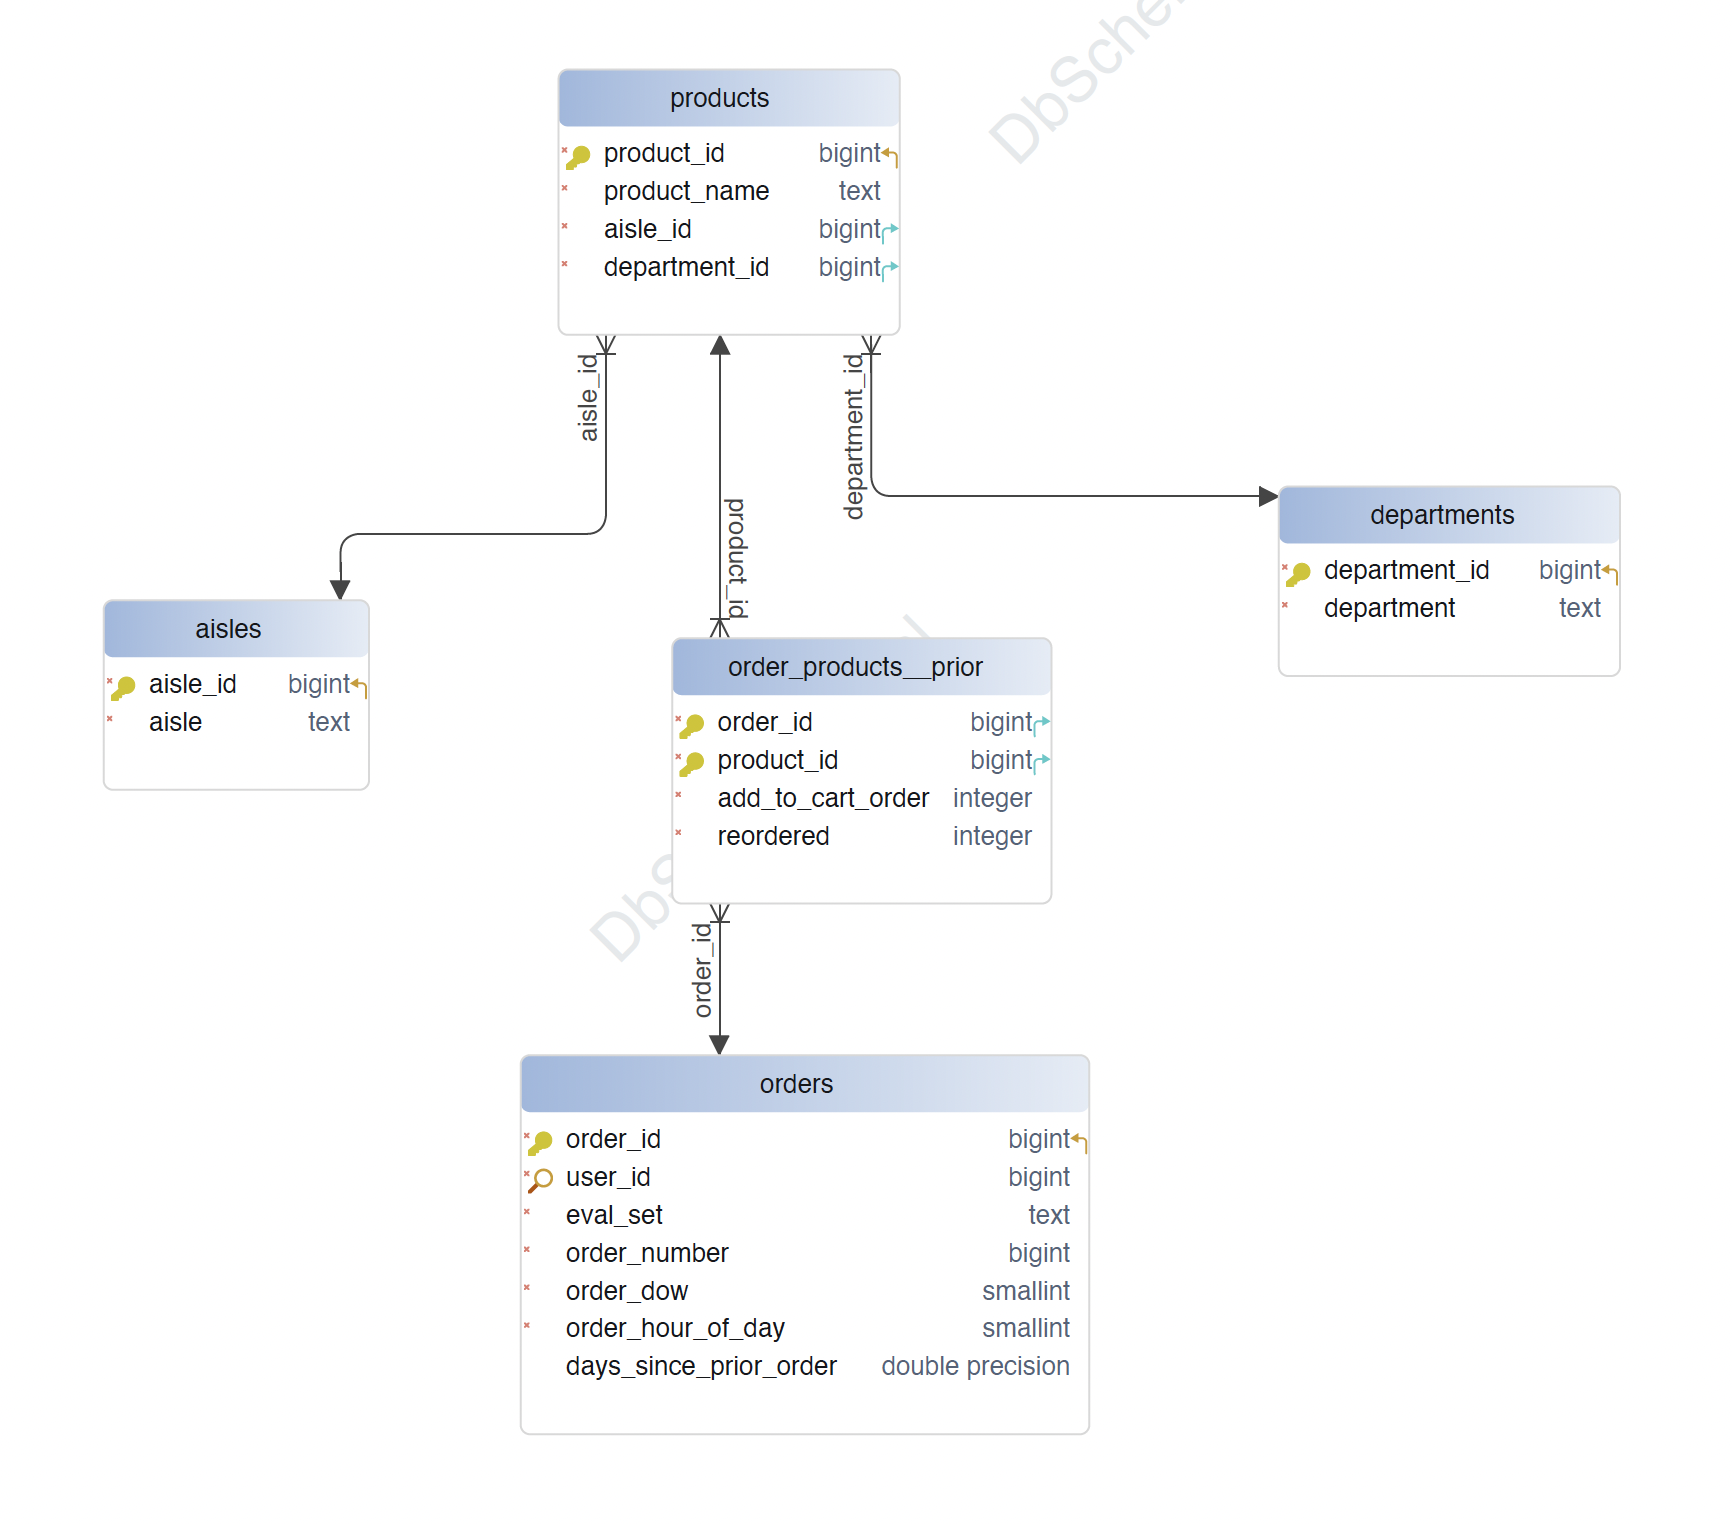

In [32]:
# Display the ER diagram image inline in the notebook
from IPython.display import Image, display
import requests
from PIL import Image as PILImage
from io import BytesIO

# URL to the image file on GitHub
img_url = "https://raw.githubusercontent.com/boratonAJ/InstacartApp/main/notebook/images/instacart_star_schema.png"

try:
    # Fetch the image from the URL
    response_img = requests.get(img_url)
    response_img.raise_for_status()  # Raise an error for bad responses (4xx or 5xx)
    img = PILImage.open(BytesIO(response_img.content))
    
    # Display the image
    display(img)
except Exception as e:
    print(f"Failed to load image from {img_url}.\nError: {e}")

The diagram shows the core Instacart relational schema for orders and products: `products`, `aisles`, `departments`, `orders`, and the join table `order_products__prior`. It models which products belong to which aisles/departments and which products appear in which orders.

**Tables & Keys**
- **`products`**:  
  - Columns: `product_id` (PK, `bigint`), `product_name` (`text`), `aisle_id` (`bigint` FK), `department_id` (`bigint` FK).  
  - Links each product to an aisle and a department.
- **`aisles`**:  
  - Columns: `aisle_id` (PK, `bigint`), `aisle` (`text`).  
  - Lookup table for aisle names.
- **`departments`**:  
  - Columns: `department_id` (PK, `bigint`), `department` (`text`).  
  - Lookup table for department names.
- **`orders`**:  
  - Columns: `order_id` (PK, `bigint`), `user_id` (`bigint`), `eval_set` (`text`), `order_number` (`bigint`), `order_dow` (`smallint`), `order_hour_of_day` (`smallint`), `days_since_prior_order` (`double precision`).  
  - Stores metadata about each order and the ordering user.
- **`order_products__prior`** (join table):  
  - Columns: `order_id` (FK to `orders.order_id`), `product_id` (FK to `products.product_id`), `add_to_cart_order` (`integer`), `reordered` (`integer`).  
  - Typical composite key: (`order_id`, `product_id`) — each row is one product within a particular order.

**Relationships**
- `products.aisle_id` → `aisles.aisle_id` (many products → one aisle).
- `products.department_id` → `departments.department_id` (many products → one department).
- `order_products__prior.product_id` → `products.product_id` and `order_products__prior.order_id` → `orders.order_id` (many-to-many between `orders` and `products`, realized by the join table).
- Arrows on the diagram indicate FK direction: product → aisle/department, order_products → orders/products.

**Cardinality & Practical Notes**
- `aisles` and `departments` are small lookup tables; `products` is medium-sized; `orders` and especially `order_products__prior` are large (historical per-order product lines).
- `add_to_cart_order` gives position of product in the cart (useful for sequence features).  
- `reordered` is a binary/integer flag indicating whether the product was previously purchased by that user (useful for repeat-buy modeling).
- `eval_set` in `orders` indicates partitioning like `train`, `test`, `prior` used in modeling workflows.

**Common JOINs / Example SQL**
- Get all products in an order:
  SELECT p.product_id, p.product_name, op.add_to_cart_order, op.reordered
  FROM `order_products__prior` op
  JOIN `products` p ON op.product_id = p.product_id
  WHERE op.order_id = <order_id>;
- Aggregate reorder rates by aisle:
  SELECT a.aisle, AVG(op.reordered) AS reorder_rate
  FROM `order_products__prior` op
  JOIN `products` p ON op.product_id = p.product_id
  JOIN `aisles` a ON p.aisle_id = a.aisle_id
  GROUP BY a.aisle
  ORDER BY reorder_rate DESC;
- User order history with timing:
  SELECT o.user_id, o.order_id, o.order_number, o.order_dow, o.order_hour_of_day, o.days_since_prior_order
  FROM `orders` o
  WHERE o.user_id = <user_id>
  ORDER BY o.order_number;

**Indexing & Performance Suggestions**
- Ensure indexes on: `products.product_id`, `aisles.aisle_id`, `departments.department_id`, `orders.order_id`, and composite index on `order_products__prior (order_id, product_id)` (or two separate indexes depending on queries).
- Consider index on `order_products__prior.product_id` if many product-centric analytics are run.
- `order_products__prior` likely dominates storage/scan time — partition or cluster it if DB supports it.

**Modeling / Analytics Uses**
- Predict next purchase / basket composition using `reordered`, `add_to_cart_order`, and user `orders` history.
- Create features: product frequency, time-of-day/day-of-week preferences, aisle/department propensity, reorder probability per product-user pair.

## 5. Extract, transform, and Loading 

### 5.1. SQL DDL

This block creates DuckDB views for:
- `aisles`
- `departments`
- `products`
- `orders`
- `orders_products_prior`

This prepares the raw CSV data for SQL processing, enabling fast relational queries without permanently importing data.

In [33]:
# Create dimension and fact tables with comments
# Use the existing connection `con` from the SQLAlchemy engine
# To avoid locking issues with DuckDB, we use the raw connection
# And then execute SQL commands

con.sql("""
DROP TABLE IF EXISTS fact_order_products;
DROP TABLE IF EXISTS dim_order;
DROP TABLE IF EXISTS dim_product;
DROP TABLE IF EXISTS dim_department;
DROP TABLE IF EXISTS dim_aisles;

CREATE TABLE dim_aisles (
    aisle_id INTEGER NOT NULL,
    aisle    VARCHAR,
    PRIMARY KEY (aisle_id)
);

COMMENT ON TABLE dim_aisles IS
    'Dimension table for Instacart aisles (store sections).';

COMMENT ON COLUMN dim_aisles.aisle_id IS
    'Unique identifier of the aisle.';
COMMENT ON COLUMN dim_aisles.aisle IS
    'Name of the aisle where products are located.';
        
CREATE TABLE dim_department (
    department_id INTEGER NOT NULL,
    department    VARCHAR,
    PRIMARY KEY (department_id)
);

COMMENT ON TABLE dim_department IS
    'Dimension table for Instacart product departments.';

COMMENT ON COLUMN dim_department.department_id IS
    'Unique identifier of the department.';
COMMENT ON COLUMN dim_department.department IS
    'Name of the department the product belongs to.';
        
CREATE TABLE dim_product (
    product_id      INTEGER NOT NULL,
    product_name    VARCHAR,
    aisle_id        INTEGER NOT NULL,
    department_id   INTEGER NOT NULL,
    PRIMARY KEY (product_id),
    FOREIGN KEY (aisle_id) REFERENCES dim_aisles(aisle_id),
    FOREIGN KEY (department_id) REFERENCES dim_department(department_id)
);

COMMENT ON TABLE dim_product IS
    'Dimension table for Instacart products, including aisle and department attributes.';

COMMENT ON COLUMN dim_product.product_id IS
    'Unique identifier of the product.';
COMMENT ON COLUMN dim_product.aisle_id IS
    'Foreign key referencing DIM_AISLES.';
COMMENT ON COLUMN dim_product.department_id IS
    'Foreign key referencing DIM_DEPARTMENT.';
COMMENT ON COLUMN dim_product.product_name IS
    'Name of the product as listed in Instacart.';
        
CREATE TABLE dim_order (
    order_id               INTEGER NOT NULL,
    user_id                INTEGER NOT NULL,
    eval_set               VARCHAR,
    order_number           INTEGER,
    order_dow              INTEGER,
    order_hour_of_day      INTEGER,
    days_since_prior_order FLOAT,
    PRIMARY KEY (order_id)
);

COMMENT ON TABLE dim_order IS
    'Dimension table describing each order, including timing and user information.';

COMMENT ON COLUMN dim_order.order_id IS
    'Unique identifier of the order.';
COMMENT ON COLUMN dim_order.user_id IS
    'Identifier of the user who placed the order.';
COMMENT ON COLUMN dim_order.eval_set IS
    'Set type: prior, train, or test.';
COMMENT ON COLUMN dim_order.order_number IS
    'Sequential number of the order for the user.';
COMMENT ON COLUMN dim_order.order_dow IS
    'Day of the week when the order was placed.';
COMMENT ON COLUMN dim_order.order_hour_of_day IS
    'Hour of the day when the order was placed.';
COMMENT ON COLUMN dim_order.days_since_prior_order IS
    'Days since the previous order (NULL for first order).';

CREATE TABLE fact_order_products (
    order_id          INTEGER NOT NULL,
    product_id        INTEGER NOT NULL,
    add_to_cart_order INTEGER,
    reordered         INTEGER,
    eval_set VARCHAR,
    PRIMARY KEY (order_id, product_id),
    FOREIGN KEY (order_id)   REFERENCES dim_order(order_id),
    FOREIGN KEY (product_id) REFERENCES dim_product(product_id)
);

COMMENT ON TABLE fact_order_products IS
    'Fact table at the grain of product-by-order (one record per item purchased).';

COMMENT ON COLUMN fact_order_products.order_id IS
    'Order identifier linking to DIM_ORDER.';
COMMENT ON COLUMN fact_order_products.product_id IS
    'Product identifier linking to DIM_PRODUCT.';
COMMENT ON COLUMN fact_order_products.add_to_cart_order IS
    'Sequence in which the product was added to the cart.';
COMMENT ON COLUMN fact_order_products.reordered IS
    'Flag indicating whether the product was previously ordered by the user.';
COMMENT ON COLUMN fact_order_products.eval_set IS
    'Set type: prior or train';
""")

### 5.2. Data Transforming

- Joining the Order Products Prior with the Order Products Train to form a single dataset
  - We know that the columns present in order_products_train and order_products_prior are same.

As noted in our dataset, 4 to 100 orders of a customer are given (we will look at this later) and we need to predict the products that will be re-ordered. So the last order of the user has been taken out and divided into train and test sets. All the prior order informations of the customer are present in order_products_prior file. We can also note that there is a column in orders.csv file called eval_set which tells us as to which of the three datasets (prior, train or test) the given row goes to.

Order_products*csv file has more detailed information about the products that been bought in the given order along with the re-ordered status.

In [34]:
#### Concatenate and merge into a single DataFrame
df_order_products_train = pd.read_csv("../"+DEST_FOLDER+"/order_products__train.csv", low_memory=False, chunksize=100000)
df_order_products_prior_train = pd.concat([order_products_prior] + [chunk for chunk in df_order_products_train])
df_order_products_prior_train.to_csv("../"+DEST_FOLDER+"/order_products_prior_train.csv", index=False, header=True)
print('Count of order products (prior + train):')
print(df_order_products_prior_train.shape[0])
df_order_products_prior_train.head(3)

Count of order products (prior + train):
33819106


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0


### 5.3. Bulk Data Loading

In [35]:
pwd

'/Users/boratonaj/Documents/GWU_Study_Course/Data Management for Analytics_DNSC_6305_81/final_project/InstacartApp/notebook/data'

In [36]:
def ingest_data(data_dir=None, threads=4, dry_run=False):
    """
    CSV-only ingestion for DuckDB with FULL TRANSACTION support.
    Loads CSVs from ./data (or provided path) into final_instacart_db
    using a single atomic transaction.

    If any part fails: whole transaction rolls back.
    If dry_run=True: transaction rolls back automatically.
    """

    import os, textwrap

    # -------------------------------------------------------
    # 1. Resolve data directory
    # -------------------------------------------------------
    candidates = [data_dir] if data_dir else []
    candidates += ['./data', '../data']

    data_dir = next((c for c in candidates if c and os.path.isdir(c)), None)
    if not data_dir:
        raise FileNotFoundError(
            "Data directory not found. Set data_dir or place CSVs in ./data."
        )

    print(f"\nStarting ingestion (transactional) from: {data_dir}\n")

    # -------------------------------------------------------
    # 2. Set DuckDB threads
    # -------------------------------------------------------
    try:
        con.execute(f"PRAGMA threads={int(threads)};")
        print(f"DuckDB threads set to {threads}")
    except:
        print("Could not set DuckDB threads—continuing")

    # -------------------------------------------------------
    # 3. Begin Transaction
    # -------------------------------------------------------
    print("Beginning DuckDB transaction...")
    con.execute("BEGIN TRANSACTION;")

    try:
        # Ensure schema exists inside the transaction
        con.execute("CREATE SCHEMA IF NOT EXISTS final_instacart_db;")

        # -------------------------------------------------------
        # 4. Dimension table definitions
        # -------------------------------------------------------
        specs = {
            "dim_aisles":      {"file": "aisles.csv",       "pk": ["aisle_id"]},
            "dim_department":  {"file": "departments.csv",  "pk": ["department_id"]},
            "dim_product":     {"file": "products.csv",     "pk": ["product_id"]},
            "dim_order":       {"file": "orders.csv",       "pk": ["order_id"]},
        }

        # -------------------------------------------------------
        # 5. Load each dimension
        # -------------------------------------------------------
        for table_name, spec in specs.items():

            file_path = os.path.join(data_dir, spec["file"])
            staging = f"stg_{table_name}"

            if not os.path.exists(file_path):
                print(f"SKIP: Missing {file_path}")
                continue

            print(f"Loading {table_name} from {file_path}")

            # Create staging from CSV
            con.execute(f"""
                CREATE OR REPLACE TABLE {staging} AS
                SELECT * 
                FROM read_csv_auto('{file_path}', header=True);
            """)

            # Dry run summary
            if dry_run:
                rows = con.execute(f"SELECT COUNT(*) FROM {staging};").fetchone()[0]
                pk = spec["pk"]
                dup = con.execute(f"""
                    SELECT COUNT(*) - COUNT(DISTINCT {','.join(pk)})
                    FROM {staging};
                """).fetchone()[0]

                print(f"[DRY RUN] rows={rows}, duplicates={dup}")
                con.execute(f"DROP TABLE IF EXISTS {staging}")
                continue

            # Load final deduped table
            pk = spec["pk"]
            pk_expr = ", ".join(pk)

            con.execute(textwrap.dedent(f"""
                CREATE OR REPLACE TABLE final_instacart_db.{table_name} AS
                SELECT *
                FROM {staging}
                QUALIFY row_number() OVER (PARTITION BY {pk_expr}) = 1;
            """))

            con.execute(f"DROP TABLE IF EXISTS {staging}")
            print(f"Loaded final_instacart_db.{table_name}")

        # -------------------------------------------------------
        # 6. Fact table: order_products
        # -------------------------------------------------------
        print("\nLoading fact_order_products...")

        prior = os.path.join(data_dir, "order_products__prior.csv")
        train = os.path.join(data_dir, "order_products__train.csv")

        parts = []
        if os.path.exists(prior): parts.append((prior, "prior"))
        if os.path.exists(train): parts.append((train, "train"))

        if not parts:
            print("No order_products files found. Skipping fact table.")
        else:
            staging_fact = "stg_fact_order_products"
            selects = []

            for path, label in parts:
                selects.append(
                    f"SELECT *, '{label}' AS eval_set FROM read_csv_auto('{path}', header=True)"
                )

            union_sql = " UNION ALL ".join(selects)

            con.execute(f"""
                CREATE OR REPLACE TABLE {staging_fact} AS
                {union_sql};
            """)

            if dry_run:
                rows = con.execute(f"SELECT COUNT(*) FROM {staging_fact};").fetchone()[0]
                dup = con.execute("""
                    SELECT COUNT(*) - COUNT(DISTINCT order_id || '_' || product_id)
                    FROM stg_fact_order_products;
                """).fetchone()[0]

                print(f"[DRY RUN] fact_order_products: rows={rows}, dup={dup}")
                con.execute("DROP TABLE IF EXISTS stg_fact_order_products")
            else:
                # Dedup into final table
                con.execute("""
                    CREATE OR REPLACE TABLE final_instacart_db.fact_order_products AS
                    SELECT *
                    FROM stg_fact_order_products
                    QUALIFY row_number() OVER (PARTITION BY order_id, product_id) = 1;
                """)
                con.execute("DROP TABLE IF EXISTS stg_fact_order_products")
                print("Loaded final_instacart_db.fact_order_products")

        # -------------------------------------------------------
        # 7. If dry-run = always rollback
        # -------------------------------------------------------
        if dry_run:
            print("\nDry run completed. Rolling back transaction...")
            con.execute("ROLLBACK;")
            print("All changes rolled back. No tables were modified.")
            return

        # -------------------------------------------------------
        # 8. Commit Transaction (Success)
        # -------------------------------------------------------
        con.execute("COMMIT;")
        print("\nTransaction committed successfully! All tables loaded.")

    except Exception as e:
        # Roll back everything if ANY error occurs
        print("\nERROR OCCURRED — rolling back transaction...")
        print("Error:", e)

        con.execute("ROLLBACK;")
        print("All changes reverted. Database is unchanged.")

ingest_data(data_dir=DEST_FOLDER, threads=4, dry_run=False)  # Perform a dry run of the data ingestion process


Starting ingestion (transactional) from: ../data

DuckDB threads set to 4
Beginning DuckDB transaction...
Loading dim_aisles from ../data/aisles.csv
Loaded final_instacart_db.dim_aisles
Loading dim_department from ../data/departments.csv
Loaded final_instacart_db.dim_department
Loading dim_product from ../data/products.csv
Loaded final_instacart_db.dim_product
Loading dim_order from ../data/orders.csv
Loaded final_instacart_db.dim_order

Loading fact_order_products...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Loaded final_instacart_db.fact_order_products

Transaction committed successfully! All tables loaded.


#### 5.3.1. List All Schemas

In [37]:
con.sql("SELECT schema_name FROM information_schema.schemata;").fetchall()

[('final_instacart_db',),
 ('main',),
 ('information_schema',),
 ('main',),
 ('pg_catalog',),
 ('main',)]

#### 5.3.2. List Tables in Your Schema

In [38]:
con.sql("""
    SELECT table_schema, table_name
    FROM information_schema.tables
    WHERE table_schema = 'final_instacart_db'
    ORDER BY table_name;
""").df()


,table_schema,table_name
0,final_instacart_db,customer_segments
1,final_instacart_db,dim_aisles
2,final_instacart_db,dim_department
3,final_instacart_db,dim_order
4,final_instacart_db,dim_product
5,final_instacart_db,fact_order_products
6,final_instacart_db,instacart_full_data
7,final_instacart_db,op_top
8,final_instacart_db,top_products


### 5.4. Data Validation & Sanity Checks

- Missing tables: If ingestion failed or schema is empty.
- Duplicate primary keys: Ensures dedupe logic worked.
- NULL violations: Confirms correct CSV loading + schema integrity.
- Foreign key integrity
    - Ensures:
        - every order_id in fact exists in dim_order
        - every product_id exists in dim_product
- Row-count sanity checks: Detects truncated or partial loads.

In [39]:
# The function prints a Pandas DataFrame summarizing all validation results.
def validate_instacart_schema(con):
    """
    Full data validation suite for final_instacart_db schema in DuckDB.
    Validates:
        - Table existence
        - Row counts
        - Primary key uniqueness
        - NOT NULL checks
        - Foreign key integrity
    Returns a dict of results and displays a Pandas summary report.
    """

    import pandas as pd

    schema = "final_instacart_db"

    # ---------------------------
    # 1. Define tables & keys
    # ---------------------------
    tables = {
        "dim_aisles": {
            "pk": ["aisle_id"],
            "not_null": ["aisle_id", "aisle"]
        },
        "dim_department": {
            "pk": ["department_id"],
            "not_null": ["department_id", "department"]
        },
        "dim_order": {
            "pk": ["order_id"],
            "not_null": ["order_id", "user_id"]
        },
        "dim_product": {
            "pk": ["product_id"],
            "not_null": ["product_id", "product_name", "aisle_id", "department_id"]
        },
        "fact_order_products": {
            "pk": ["order_id", "product_id"],
            "not_null": ["order_id", "product_id"],
            "foreign_keys": {
                "order_id": ("dim_order", "order_id"),
                "product_id": ("dim_product", "product_id")
            }
        }
    }

    results = {}

    # ---------------------------
    # 2. Iterate through tables
    # ---------------------------
    for table_name, config in tables.items():

        full_table = f"{schema}.{table_name}"
        table_result = {}

        # Table existence check
        exists = con.sql(f"""
            SELECT COUNT(*) 
            FROM information_schema.tables
            WHERE table_schema='{schema}' AND table_name='{table_name}'
        """).fetchone()[0] > 0

        table_result["exists"] = exists

        if not exists:
            results[table_name] = table_result
            continue

        # Row count
        table_result["row_count"] = con.sql(f"""
            SELECT COUNT(*) FROM {full_table}
        """).fetchone()[0]

        # Primary key duplicates
        pk_cols = config.get("pk", [])
        if pk_cols:
            if len(pk_cols) == 1:
                pk_expr = pk_cols[0]
            else:
                # concatenate multiple columns to handle multi-column PK
                pk_expr = " || '-' || ".join(pk_cols)

            duplicates = con.sql(f"""
                SELECT total_rows - unique_rows AS dup_count
                FROM (
                    SELECT COUNT(*) AS total_rows,
                           COUNT(DISTINCT {pk_expr}) AS unique_rows
                    FROM {full_table}
                )
            """).fetchone()[0]

            table_result["duplicate_pk_rows"] = int(duplicates)

        # NOT NULL checks
        null_checks = {}
        for col in config.get("not_null", []):
            null_count = con.sql(f"""
                SELECT COUNT(*) FROM {full_table} WHERE {col} IS NULL
            """).fetchone()[0]
            null_checks[col] = int(null_count)
        table_result["null_checks"] = null_checks

        # Foreign key validation
        fk_checks = {}
        for col, (ref_table, ref_col) in config.get("foreign_keys", {}).items():
            missing_count = con.sql(f"""
                SELECT COUNT(*)
                FROM {full_table} t
                LEFT JOIN {schema}.{ref_table} d
                    ON t.{col} = d.{ref_col}
                WHERE d.{ref_col} IS NULL
            """).fetchone()[0]
            fk_checks[col] = {
                "ref_table": ref_table,
                "missing_keys": int(missing_count)
            }
        table_result["foreign_keys"] = fk_checks

        results[table_name] = table_result

    # ---------------------------
    # 3. Create summary report
    # ---------------------------
    report = pd.DataFrame([
        {
            "table": tbl,
            "exists": res.get("exists", False),
            "rows": res.get("row_count", None),
            "duplicate_pk_rows": res.get("duplicate_pk_rows", None),
            "nulls": res.get("null_checks", {}),
            "fk_violations": res.get("foreign_keys", {})
        }
        for tbl, res in results.items()
    ])

    print("\n📊 **INSTACART DATA VALIDATION REPORT**")
    display(report)


In [40]:
validation_results = validate_instacart_schema(con)
validation_results



📊 **INSTACART DATA VALIDATION REPORT**


,table,exists,rows,duplicate_pk_rows,nulls,fk_violations
0,dim_aisles,True,134,0,"{'aisle_id': 0, 'aisle': 0}",{}
1,dim_department,True,21,0,"{'department_id': 0, 'department': 0}",{}
2,dim_order,True,3421083,0,"{'order_id': 0, 'user_id': 0}",{}
3,dim_product,True,49688,0,"{'product_id': 0, 'product_name': 0, 'aisle_id...",{}
4,fact_order_products,True,33819106,0,"{'order_id': 0, 'product_id': 0}","{'order_id': {'ref_table': 'dim_order', 'missi..."


In [41]:
con.sql("SELECT * FROM final_instacart_db.dim_aisles LIMIT 5;")

┌──────────┬───────────────┐
│ aisle_id │     aisle     │
│  int64   │    varchar    │
├──────────┼───────────────┤
│       53 │ cream         │
│      113 │ frozen juice  │
│      126 │ feminine care │
│        4 │ instant foods │
│       23 │ popcorn jerky │
└──────────┴───────────────┘

In [42]:
con.sql("SELECT COUNT(*) AS total_aisles FROM final_instacart_db.dim_aisles;")

┌──────────────┐
│ total_aisles │
│    int64     │
├──────────────┤
│          134 │
└──────────────┘

In [43]:
!csvstat --count ../data/aisles.csv

134


In [44]:
# con.sql("""
# COPY dim_department
# FROM '../data/departments.csv'
# (HEADER TRUE, DELIMITER ',');
# """)

In [45]:
con.sql("SELECT * FROM final_instacart_db.dim_department LIMIT 5;")

┌───────────────┬───────────────┐
│ department_id │  department   │
│     int64     │    varchar    │
├───────────────┼───────────────┤
│            15 │ canned goods  │
│             2 │ other         │
│            11 │ personal care │
│            16 │ dairy eggs    │
│            12 │ meat seafood  │
└───────────────┴───────────────┘

In [46]:
con.sql("SELECT COUNT(*) AS total_departments FROM final_instacart_db.dim_department;")

┌───────────────────┐
│ total_departments │
│       int64       │
├───────────────────┤
│                21 │
└───────────────────┘

In [47]:
!csvstat --count ../data/departments.csv

21


In [48]:
# con.sql("""
# COPY dim_product (product_id, product_name, aisle_id, department_id)
# FROM '../data/products.csv'
# (HEADER TRUE, DELIMITER ',');
# """)

In [49]:
con.sql("SELECT * FROM final_instacart_db.dim_product LIMIT 5;")

┌────────────┬─────────────────────────────────────────────┬──────────┬───────────────┐
│ product_id │                product_name                 │ aisle_id │ department_id │
│   int64    │                   varchar                   │  int64   │     int64     │
├────────────┼─────────────────────────────────────────────┼──────────┼───────────────┤
│          3 │ Robust Golden Unsweetened Oolong Tea        │       94 │             7 │
│          6 │ Dry Nose Oil                                │       11 │            11 │
│         38 │ Ultra Antibacterial Dish Liquid             │      100 │            21 │
│         41 │ Organic Sourdough Einkorn Crackers Rosemary │       78 │            19 │
│         58 │ Whole Wheat Tortillas                       │      128 │             3 │
└────────────┴─────────────────────────────────────────────┴──────────┴───────────────┘

In [50]:
con.sql("SELECT COUNT(*) AS total_departments FROM final_instacart_db.dim_product;")

┌───────────────────┐
│ total_departments │
│       int64       │
├───────────────────┤
│             49688 │
└───────────────────┘

In [51]:
!csvstat --count ../data/products.csv

49688


In [52]:
# con.sql("""
# COPY dim_order (
#     order_id,
#     user_id,
#     eval_set,
#     order_number,
#     order_dow,
#     order_hour_of_day,
#     days_since_prior_order
# )
# FROM '../data/orders.csv'
# (HEADER TRUE, DELIMITER ',');
# """)

In [53]:
con.sql("SELECT COUNT(*) AS total_orders FROM final_instacart_db.dim_order;")

┌──────────────┐
│ total_orders │
│    int64     │
├──────────────┤
│      3421083 │
└──────────────┘

In [54]:
con.sql("SELECT * FROM final_instacart_db.dim_order LIMIT 5;")

┌──────────┬─────────┬──────────┬──────────────┬───────────┬───────────────────┬────────────────────────┐
│ order_id │ user_id │ eval_set │ order_number │ order_dow │ order_hour_of_day │ days_since_prior_order │
│  int64   │  int64  │ varchar  │    int64     │   int64   │      varchar      │         double         │
├──────────┼─────────┼──────────┼──────────────┼───────────┼───────────────────┼────────────────────────┤
│        3 │  205970 │ prior    │           16 │         5 │ 17                │                   12.0 │
│       38 │   42756 │ train    │            6 │         6 │ 16                │                   24.0 │
│       41 │   85264 │ prior    │           20 │         2 │ 11                │                   21.0 │
│       76 │   75136 │ prior    │            5 │         1 │ 19                │                   30.0 │
│       82 │   83499 │ prior    │           20 │         1 │ 13                │                    3.0 │
└──────────┴─────────┴──────────┴─────────────

In [55]:
!csvstat --count ../data/orders.csv

3421083


In [56]:
con.sql("DESCRIBE final_instacart_db.fact_order_products;")

┌───────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│    column_name    │ column_type │  null   │   key   │ default │  extra  │
│      varchar      │   varchar   │ varchar │ varchar │ varchar │ varchar │
├───────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ order_id          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ product_id        │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ add_to_cart_order │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ reordered         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ eval_set          │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
└───────────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [57]:
# # Insert data into fact_order_products using a SELECT statement
# con.sql("""
# INSERT INTO fact_order_products (order_id, product_id, add_to_cart_order, reordered, eval_set)
# SELECT
#     order_id,
#     product_id,
#     add_to_cart_order,
#     reordered,
#     'prior' AS eval_set
# FROM read_csv_auto('../data/order_products__prior.csv', header=True)

# UNION ALL

# SELECT
#     order_id,
#     product_id,
#     add_to_cart_order,
#     reordered,
#     'train' AS eval_set
# FROM read_csv_auto('../data/order_products__train.csv', header=True);
# """)


In [58]:
con.sql("SELECT COUNT(*) AS total_orders_products FROM final_instacart_db.fact_order_products;")

┌───────────────────────┐
│ total_orders_products │
│         int64         │
├───────────────────────┤
│              33819106 │
└───────────────────────┘

In [59]:
con.sql("SELECT * FROM final_instacart_db.fact_order_products LIMIT 5;")

┌──────────┬────────────┬───────────────────┬───────────┬──────────┐
│ order_id │ product_id │ add_to_cart_order │ reordered │ eval_set │
│  int64   │   int64    │       int64       │   int64   │ varchar  │
├──────────┼────────────┼───────────────────┼───────────┼──────────┤
│  1781582 │      27966 │                 2 │         1 │ prior    │
│  1781633 │      39928 │                 5 │         1 │ prior    │
│  1781646 │       5068 │                 5 │         0 │ train    │
│  1781647 │       5240 │                 7 │         0 │ prior    │
│  1781679 │      41950 │                21 │         1 │ prior    │
└──────────┴────────────┴───────────────────┴───────────┴──────────┘

In [60]:
!awk 'END{print NR}' ../data/order_products_prior_train.csv

33819107


In [61]:
con.sql("SHOW TABLES;")

┌─────────────────────┐
│        name         │
│       varchar       │
├─────────────────────┤
│ dim_aisles          │
│ dim_department      │
│ dim_order           │
│ dim_product         │
│ fact_order_products │
│ op_top              │
│ top_products        │
└─────────────────────┘

Executing `SHOW TABLES` confirms that DuckDB successfully registered five dimension tables.
These tables serve as the foundational building blocks for downstream analysis (joins, aggregations, feature engineering).

In [62]:
# Ensure the schema exists
con.sql("CREATE SCHEMA IF NOT EXISTS final_instacart_db;")

# Define the SQL query to create the instacart_full_data table in the schema
instacart_full_query = """
DROP TABLE IF EXISTS final_instacart_db.instacart_full_data;
CREATE TABLE final_instacart_db.instacart_full_data AS
SELECT
    op.order_id,
    op.product_id,
    op.add_to_cart_order,
    op.reordered,
    p.product_name,
    a.aisle,
    d.department,
    o.user_id,
    o.eval_set,
    o.order_number,
    o.order_dow,
    o.order_hour_of_day,
    o.days_since_prior_order AS days_since_prior
FROM final_instacart_db.fact_order_products op
LEFT JOIN final_instacart_db.dim_product p
    ON op.product_id = p.product_id
LEFT JOIN final_instacart_db.dim_aisles a
    ON p.aisle_id = a.aisle_id
LEFT JOIN final_instacart_db.dim_department d
    ON p.department_id = d.department_id
LEFT JOIN final_instacart_db.dim_order o
    ON op.order_id = o.order_id
WHERE o.eval_set = 'prior';
"""

# Execute the query
con.sql(instacart_full_query)

# Fetch and display a sample
result_df = con.execute("SELECT * FROM final_instacart_db.instacart_full_data LIMIT 5;").fetchdf()
display(result_df)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior
0,1781582,27966,2,1,Organic Raspberries,packaged vegetables fruits,produce,77924,prior,33,2,17,25.0
1,1781633,39928,5,1,Organic Kiwi,fresh fruits,produce,41362,prior,5,6,08,13.0
2,1781647,5240,7,0,Spaghetti No 12,dry pasta,dry goods pasta,161346,prior,52,2,18,3.0
3,1781679,41950,21,1,Organic Tomato Cluster,fresh vegetables,produce,110916,prior,45,2,09,6.0
4,1781740,24024,2,1,1% Lowfat Milk,milk,dairy eggs,142560,prior,5,2,14,8.0


This is the most important cell so far.
It joins all dimension tables into one unified dataset using:
- product details
- aisle & department information
- user and order metadata
- prior order product-level records
- Filtering `eval_set = 'prior'` ensures only historical transactions are included for modeling.
- The resulting table (`instacart_full_data`) contains over 32 million rows, matching the size of the prior orders file. This wide table is used for EDA and feature engineering.

In [63]:
con.sql("SELECT COUNT(*) FROM final_instacart_db.instacart_full_data;")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│     32434489 │
└──────────────┘

The output confirms:
- `📌 32,434,489 records`
- This verifies that the unified dataset properly integrates all prior order interactions across users and products.

In [64]:
con.sql("SHOW TABLES;")

┌─────────────────────┐
│        name         │
│       varchar       │
├─────────────────────┤
│ dim_aisles          │
│ dim_department      │
│ dim_order           │
│ dim_product         │
│ fact_order_products │
│ op_top              │
│ top_products        │
└─────────────────────┘

## 6. Data Exploratory Analysis 
We find the;

- Total Number of users and products
- Top 20 most purchased items
- Reorder rate
- Basket size Distribution
- Order per day of the week
- Order per hour of the day
- Products with highest reorder probability
- Department with highest reorder probability
- Products that are most commonly purchased together
- Identify commonly co-purchased products
- Overall view of how frequently customers place orders
- Identifying the most active customers those who reorder extremely frequently
- Dashboard of all plots

### 6.1. Total Number of users and products

In [65]:
con.sql("""
SELECT
    COUNT(DISTINCT user_id) AS n_users,
    COUNT(DISTINCT product_id) AS n_products
FROM final_instacart_db.instacart_full_data;
""")

┌─────────┬────────────┐
│ n_users │ n_products │
│  int64  │   int64    │
├─────────┼────────────┤
│  206209 │      49677 │
└─────────┴────────────┘

This cell checks dataset richness by counting distinct IDs:
- 206,209 unique users
- 49,677 unique products

This highlights the scale and diversity of Instacart’s marketplace, making it suitable for behavioral modeling and recommendation systems.

### 6.2. Top 20 most purchased items

In [66]:
con.sql("""
SELECT
    product_name,
    COUNT(*) AS times_ordered
FROM final_instacart_db.instacart_full_data
GROUP BY product_name
ORDER BY times_ordered DESC
LIMIT 20;
"""
)

┌──────────────────────────┬───────────────┐
│       product_name       │ times_ordered │
│         varchar          │     int64     │
├──────────────────────────┼───────────────┤
│ Banana                   │        472565 │
│ Bag of Organic Bananas   │        379450 │
│ Organic Strawberries     │        264683 │
│ Organic Baby Spinach     │        241921 │
│ Organic Hass Avocado     │        213584 │
│ Organic Avocado          │        176815 │
│ Large Lemon              │        152657 │
│ Strawberries             │        142951 │
│ Limes                    │        140627 │
│ Organic Whole Milk       │        137905 │
│ Organic Raspberries      │        137057 │
│ Organic Yellow Onion     │        113426 │
│ Organic Garlic           │        109778 │
│ Organic Zucchini         │        104823 │
│ Organic Blueberries      │        100060 │
│ Cucumber Kirby           │         97315 │
│ Organic Fuji Apple       │         89632 │
│ Organic Lemon            │         87746 │
│ Apple Ho

This SQL query aggregates purchase frequencies by product name.
Key findings:
- Bananas are the #1 purchased item (472,565 orders)
- Other highly purchased items include strawberries, avocados, organic milk, and lemons.
- This is typical for Instacart: fresh produce dominates reorder frequency.
This insight is foundational for recommendation engines.

### 6.3. Reorder rate

In [67]:
con.sql("""
SELECT
    AVG(reordered)::DOUBLE AS reorder_rate
FROM final_instacart_db.instacart_full_data;
""")

┌────────────────────┐
│    reorder_rate    │
│       double       │
├────────────────────┤
│ 0.5896974667922161 │
└────────────────────┘

The query computes the overall reorder probability across all transactions.
- `📌 Reorder Rate: ~0.59 (59%)`
Interpretation:
- More than half of all purchased products are repeat purchases.
- This shows strong customer loyalty patterns and predictable shopping habits, ideal for modeling reorder behavior.

### 6.4. Basket size Distribution

In [68]:
con.sql("""
SELECT
    item_count,
    COUNT(*) AS n_orders
FROM (
    SELECT order_id, COUNT(*) AS item_count
    FROM final_instacart_db.instacart_full_data
    GROUP BY order_id
)
GROUP BY item_count
ORDER BY item_count
LIMIT 10;
""")

┌────────────┬──────────┐
│ item_count │ n_orders │
│   int64    │  int64   │
├────────────┼──────────┤
│          1 │   156748 │
│          2 │   186993 │
│          3 │   207027 │
│          4 │   222081 │
│          5 │   228330 │
│          6 │   227675 │
│          7 │   220006 │
│          8 │   203374 │
│          9 │   184347 │
│         10 │   165550 │
├────────────┴──────────┤
│ 10 rows     2 columns │
└───────────────────────┘

This cell calculates how many items appear in each order and counts how many orders fall into each basket size.
- Basket sizes range widely but small baskets (1–10 items) are the most common.
- The most frequent basket sizes are around 3–7 items.

This helps understand user shopping intensity and can be used as a regression input feature.

### 6.5. Order per day of the week

In [69]:
con.sql("""
SELECT
    order_dow as day_of_week, -- 0=Sunday, 1=Monday, ..., 6=Saturday
    COUNT(*) AS n_orders
FROM final_instacart_db.instacart_full_data
GROUP BY order_dow
ORDER BY order_dow;
""")

┌─────────────┬──────────┐
│ day_of_week │ n_orders │
│    int64    │  int64   │
├─────────────┼──────────┤
│           0 │  6209666 │
│           1 │  5665856 │
│           2 │  4217798 │
│           3 │  3844117 │
│           4 │  3787215 │
│           5 │  4209533 │
│           6 │  4500304 │
└─────────────┴──────────┘

This query groups total orders by day of the week (order_dow).

Findings:
- Sunday (0) is the busiest shopping day (over 6M orders).
- Midweek shopping drops significantly.
- Activity rises again on Friday and Saturday.

This pattern reflects typical weekend grocery behavior and is useful for weekly demand forecasting.

### 6.6. Order per hour of the day

In [70]:
con.sql("""
SELECT
    order_hour_of_day,
    COUNT(*) AS n_orders
FROM final_instacart_db.instacart_full_data
GROUP BY order_hour_of_day
ORDER BY order_hour_of_day
LIMIT 24;
""")

┌───────────────────┬──────────┐
│ order_hour_of_day │ n_orders │
│      varchar      │  int64   │
├───────────────────┼──────────┤
│ 00                │   218948 │
│ 01                │   115786 │
│ 02                │    69434 │
│ 03                │    51321 │
│ 04                │    53283 │
│ 05                │    88062 │
│ 06                │   290795 │
│ 07                │   891937 │
│ 08                │  1719973 │
│ 09                │  2456713 │
│ ·                 │     ·    │
│ ·                 │     ·    │
│ ·                 │     ·    │
│ 14                │  2691548 │
│ 15                │  2664533 │
│ 16                │  2537458 │
│ 17                │  2089465 │
│ 18                │  1637923 │
│ 19                │  1259401 │
│ 20                │   977038 │
│ 21                │   796370 │
│ 22                │   634734 │
│ 23                │   402620 │
├───────────────────┴──────────┤
│ 24 rows (20 shown) 2 columns │
└──────────────────────────────┘

This shows ordering behavior throughout the day.
    
There is a sharp increase starting at `7 AM`, peaking around `10 AM–5 PM`, and declining after evening hours.
This indicates that Instacart is most popular during daytime hours when shoppers plan their meals or household needs.

### 6.7. Products with highest reorder probability

In [71]:
con.sql("""
SELECT
    product_name,
    COUNT(*) AS total_orders,
    AVG(reordered)::DOUBLE AS reorder_rate
FROM final_instacart_db.instacart_full_data
GROUP BY product_name
HAVING COUNT(*) > 200
ORDER BY total_orders DESC
LIMIT 20;
""")


┌──────────────────────────┬──────────────┬────────────────────┐
│       product_name       │ total_orders │    reorder_rate    │
│         varchar          │    int64     │       double       │
├──────────────────────────┼──────────────┼────────────────────┤
│ Banana                   │       472565 │ 0.8435008940569022 │
│ Bag of Organic Bananas   │       379450 │  0.832555013835815 │
│ Organic Strawberries     │       264683 │ 0.7777038948477991 │
│ Organic Baby Spinach     │       241921 │ 0.7725001136734719 │
│ Organic Hass Avocado     │       213584 │ 0.7965531125927036 │
│ Organic Avocado          │       176815 │ 0.7581031021123773 │
│ Large Lemon              │       152657 │ 0.6960375220265038 │
│ Strawberries             │       142951 │ 0.6981553119600422 │
│ Limes                    │       140627 │ 0.6810072034531064 │
│ Organic Whole Milk       │       137905 │ 0.8303542293607918 │
│ Organic Raspberries      │       137057 │ 0.7690887732841081 │
│ Organic Yellow Onion   

This analysis identifies products that customers are most likely to reorder, considering only products with at least 200 prior orders to ensure statistical reliability. The results reveal that dairy and water-based items dominate the top of the list, with reorder probabilities consistently above 85%. Items such as Ultra-Purified Water, Organic Whole Milk, Organic Lactose-Free Milk, and Whole Organic Omega 3 Milk appear frequently.

These products share two characteristics: they are essential, frequently consumed, and regularly replenished, which naturally leads to strong repeat behavior. High reorder probability in these items suggests strong brand loyalty and predictable repurchasing cycles, making them ideal candidates for subscription programs, proactive recommendations, and inventory prioritization.

### 6.8. Department with highest reorder probability

In [72]:
con.sql("""
SELECT
    department,
    COUNT(*) AS total_items,
    AVG(reordered)::DOUBLE AS reorder_rate
FROM final_instacart_db.instacart_full_data
GROUP BY department
ORDER BY total_items DESC;
""")

┌─────────────────┬─────────────┬─────────────────────┐
│   department    │ total_items │    reorder_rate     │
│     varchar     │    int64    │       double        │
├─────────────────┼─────────────┼─────────────────────┤
│ produce         │     9479291 │  0.6499125303780631 │
│ dairy eggs      │     5414016 │  0.6699686517365298 │
│ snacks          │     2887550 │  0.5741798410417136 │
│ beverages       │     2690129 │  0.6534601128793452 │
│ frozen          │     2236432 │  0.5418854675661947 │
│ pantry          │     1875577 │  0.3467205025440171 │
│ bakery          │     1176787 │  0.6281408615152955 │
│ canned goods    │     1068058 │  0.4574049349379903 │
│ deli            │     1051249 │  0.6077190085317561 │
│ dry goods pasta │      866627 │  0.4610761030985649 │
│ household       │      738666 │ 0.40217770954666926 │
│ breakfast       │      709569 │  0.5609221936133061 │
│ meat seafood    │      708931 │  0.5676744281178281 │
│ personal care   │      447123 │ 0.321128637981

This analysis aggregates reorder rates at the department level. The Produce department has the highest total purchase volume and a strong reorder probability, followed closely by Dairy & Eggs, Snacks, and Beverages.

Departments with high reorder rates typically include perishable or consumable items that customers buy repeatedly. For example, fruits, vegetables, milk, and snacks are purchased frequently due to perishability or routine household consumption. Conversely, departments such as Pantry, Dry Goods, and Household show lower reorder rates these products have longer shelf lives and are restocked less often.

These insights help Instacart understand which departments drive customer retention and which categories may require marketing incentives to increase repeat purchases.

### 6.9. Products that are most commonly purchased together

In [73]:
con.sql("""
CREATE OR REPLACE VIEW final_instacart_db.top_products AS
SELECT
    product_id,
    COUNT(*) AS times_ordered
FROM final_instacart_db.fact_order_products
GROUP BY product_id
ORDER BY times_ordered DESC
LIMIT 200;
""")

In [74]:
con.sql("""
CREATE OR REPLACE VIEW final_instacart_db.op_top AS
SELECT op.*
FROM final_instacart_db.fact_order_products op
JOIN final_instacart_db.top_products t USING (product_id);
""")

In [75]:
con.sql("""
WITH pairs AS (
    SELECT
        a.order_id,
        a.product_id AS product_a,
        b.product_id AS product_b
    FROM final_instacart_db.op_top a
    JOIN final_instacart_db.op_top b
      ON a.order_id = b.order_id
     AND a.product_id < b.product_id
)
SELECT
    p1.product_name AS product_a_name,
    p2.product_name AS product_b_name,
    COUNT(*)        AS times_bought_together
FROM pairs
JOIN final_instacart_db.dim_product p1 ON p1.product_id = pairs.product_a
JOIN final_instacart_db.dim_product p2 ON p2.product_id = pairs.product_b
GROUP BY
    p1.product_name,
    p2.product_name
ORDER BY times_bought_together DESC
LIMIT 10;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────────┬──────────────────────┬───────────────────────┐
│     product_a_name     │    product_b_name    │ times_bought_together │
│        varchar         │       varchar        │         int64         │
├────────────────────────┼──────────────────────┼───────────────────────┤
│ Bag of Organic Bananas │ Organic Hass Avocado │                 64761 │
│ Bag of Organic Bananas │ Organic Strawberries │                 64702 │
│ Organic Strawberries   │ Banana               │                 58330 │
│ Banana                 │ Organic Avocado      │                 55611 │
│ Organic Baby Spinach   │ Banana               │                 53395 │
│ Bag of Organic Bananas │ Organic Baby Spinach │                 52608 │
│ Strawberries           │ Banana               │                 43180 │
│ Banana                 │ Large Lemon          │                 43038 │
│ Organic Strawberries   │ Organic Hass Avocado │                 42333 │
│ Bag of Organic Bananas │ Organic Ras

This section identifies product pairs that frequently appear within the same shopping cart. The most common combinations include complementary produce items such as Bag of Organic Bananas + Organic Hass Avocado, Strawberries + Bananas, and Organic Baby Spinach + Bananas.

These associations indicate natural purchasing patterns fruits and vegetables tend to be purchased together, and certain combinations likely reflect meal planning habits (smoothies, salads, snacks).

These insights are especially valuable for recommendation systems (“Customers also bought…”) and for designing targeted promotions or product bundles.

### 6.10. Identify commonly co-purchased products

To identify commonly co-purchased products, I restricted the analysis to the top 200 most frequently ordered items (to avoid combinatorial explosion in pair counts). Within this subset, I computed product pairs that appear in the same order and ranked them by co-occurrence frequency

In [76]:
con.sql("""
CREATE OR REPLACE VIEW final_instacart_db.customer_segments AS
SELECT
    user_id,
    COUNT(DISTINCT order_id) AS n_orders,
    CASE
        WHEN COUNT(*) > 50 THEN 'Heavy Buyer'
        WHEN COUNT(*) BETWEEN 15 AND 50 THEN 'Regular Buyer'
        ELSE 'Light Buyer'
    END AS segment
FROM final_instacart_db.instacart_full_data
GROUP BY user_id;
""")

In [77]:
con.sql("""
SELECT
    segment,
    AVG(reordered)::DOUBLE AS avg_reorder_rate
FROM final_instacart_db.instacart_full_data f
JOIN final_instacart_db.customer_segments s USING (user_id)
GROUP BY segment
ORDER BY avg_reorder_rate DESC;
""")

┌───────────────┬─────────────────────┐
│    segment    │  avg_reorder_rate   │
│    varchar    │       double        │
├───────────────┼─────────────────────┤
│ Heavy Buyer   │  0.6082981115369542 │
│ Regular Buyer │ 0.29559132576170394 │
│ Light Buyer   │  0.2947634834064093 │
└───────────────┴─────────────────────┘

Customers are segmented based on the number of orders they have placed:
- Heavy Buyers: More than 50 orders
- Regular Buyers: Between 15 and 50 orders
- Light Buyers: Fewer than 15 orders

This segmentation provides a behavioral understanding of Instacart’s user base. Heavy buyers represent highly engaged customers who rely on Instacart for routine shopping. Regular buyers demonstrate consistent but moderate usage, while light buyers are occasional users or new customers in early stages of adoption.

### 6.11. Overall view of how frequently customers place orders

In [78]:
con.sql("""
SELECT
    AVG(days_since_prior_order)::DOUBLE AS avg_days_between_orders,
    MIN(days_since_prior_order)         AS min_days,
    MAX(days_since_prior_order)         AS max_days
FROM final_instacart_db.dim_order
WHERE days_since_prior_order IS NOT NULL;
""")

┌─────────────────────────┬──────────┬──────────┐
│ avg_days_between_orders │ min_days │ max_days │
│         double          │  double  │  double  │
├─────────────────────────┼──────────┼──────────┤
│      11.114836226863012 │      0.0 │     30.0 │
└─────────────────────────┴──────────┴──────────┘

This analysis provides an overall view of how frequently customers place orders:

- Average gap: ~11.1 days
- Minimum: 0 days
- Maximum: 30 days

The average suggests that most users treat Instacart as a weekly or bi-weekly shopping solution. The minimum value indicates same-day multiple orders or extremely frequent shoppers, while the maximum reflects the dataset’s cutoff, as Instacart caps this variable at 30 days.

Understanding order frequency helps support forecasting, retention strategy design, and predicting customer lifetime value.

### 6.12. Identifying the most active customers those who reorder extremely frequently

In [79]:
con.sql("""
SELECT
    o.user_id,
    AVG(o.days_since_prior_order)        AS avg_days_between_orders,
    AVG(f.reordered)::DOUBLE             AS reorder_probability
FROM final_instacart_db.dim_order o
JOIN final_instacart_db.instacart_full_data f
  ON o.order_id = f.order_id
WHERE o.days_since_prior_order IS NOT NULL
GROUP BY o.user_id
ORDER BY avg_days_between_orders ASC
LIMIT 50;
""")

┌─────────┬─────────────────────────┬─────────────────────┐
│ user_id │ avg_days_between_orders │ reorder_probability │
│  int64  │         double          │       double        │
├─────────┼─────────────────────────┼─────────────────────┤
│  133075 │                     0.0 │                 0.8 │
│   58934 │                     0.0 │               0.125 │
│  164320 │                     0.0 │                 1.0 │
│  181478 │                     0.0 │                 1.0 │
│   80567 │                     0.0 │                 0.0 │
│    9515 │                     0.0 │                 1.0 │
│   62180 │                     0.0 │  0.6666666666666666 │
│  174627 │                     0.0 │                 1.0 │
│   74329 │                     0.0 │                 0.0 │
│  201321 │                     0.0 │                 1.0 │
│     ·   │                      ·  │                  ·  │
│     ·   │                      ·  │                  ·  │
│     ·   │                      ·  │   

This query identifies the most active customers those who reorder extremely frequently. These users have 0 to 1-day gaps between orders and often exhibit very high reorder probabilities.

These customers are highly valuable because they:
- Use Instacart almost daily or multiple times per week
- Have extremely predictable purchasing behavior
- Are strong candidates for premium programs or membership tiers

Highlighting these users supports customer lifetime value modeling and helps Instacart focus on maintaining its most loyal customer base.

### 6.13. Dashboard of all plots

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/var/folders/_g/9grbj50n61gcmlfd1qysf27w0000gn/T/ipykernel_23950/4068207634.py:125: UserWarning: 
The palette list has fewer values (6) than needed (21) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
/var/folders/_g/9grbj50n61gcmlfd1qysf27w0000gn/T/ipykernel_23950/4068207634.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_pairs_plot, x="times_bought_together", y="pair", ax=ax4, palette="magma")
/var/folders/_g/9grbj50n61gcmlfd1qysf27w0000gn/T/ipykernel_23950/4068207634.py:187: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


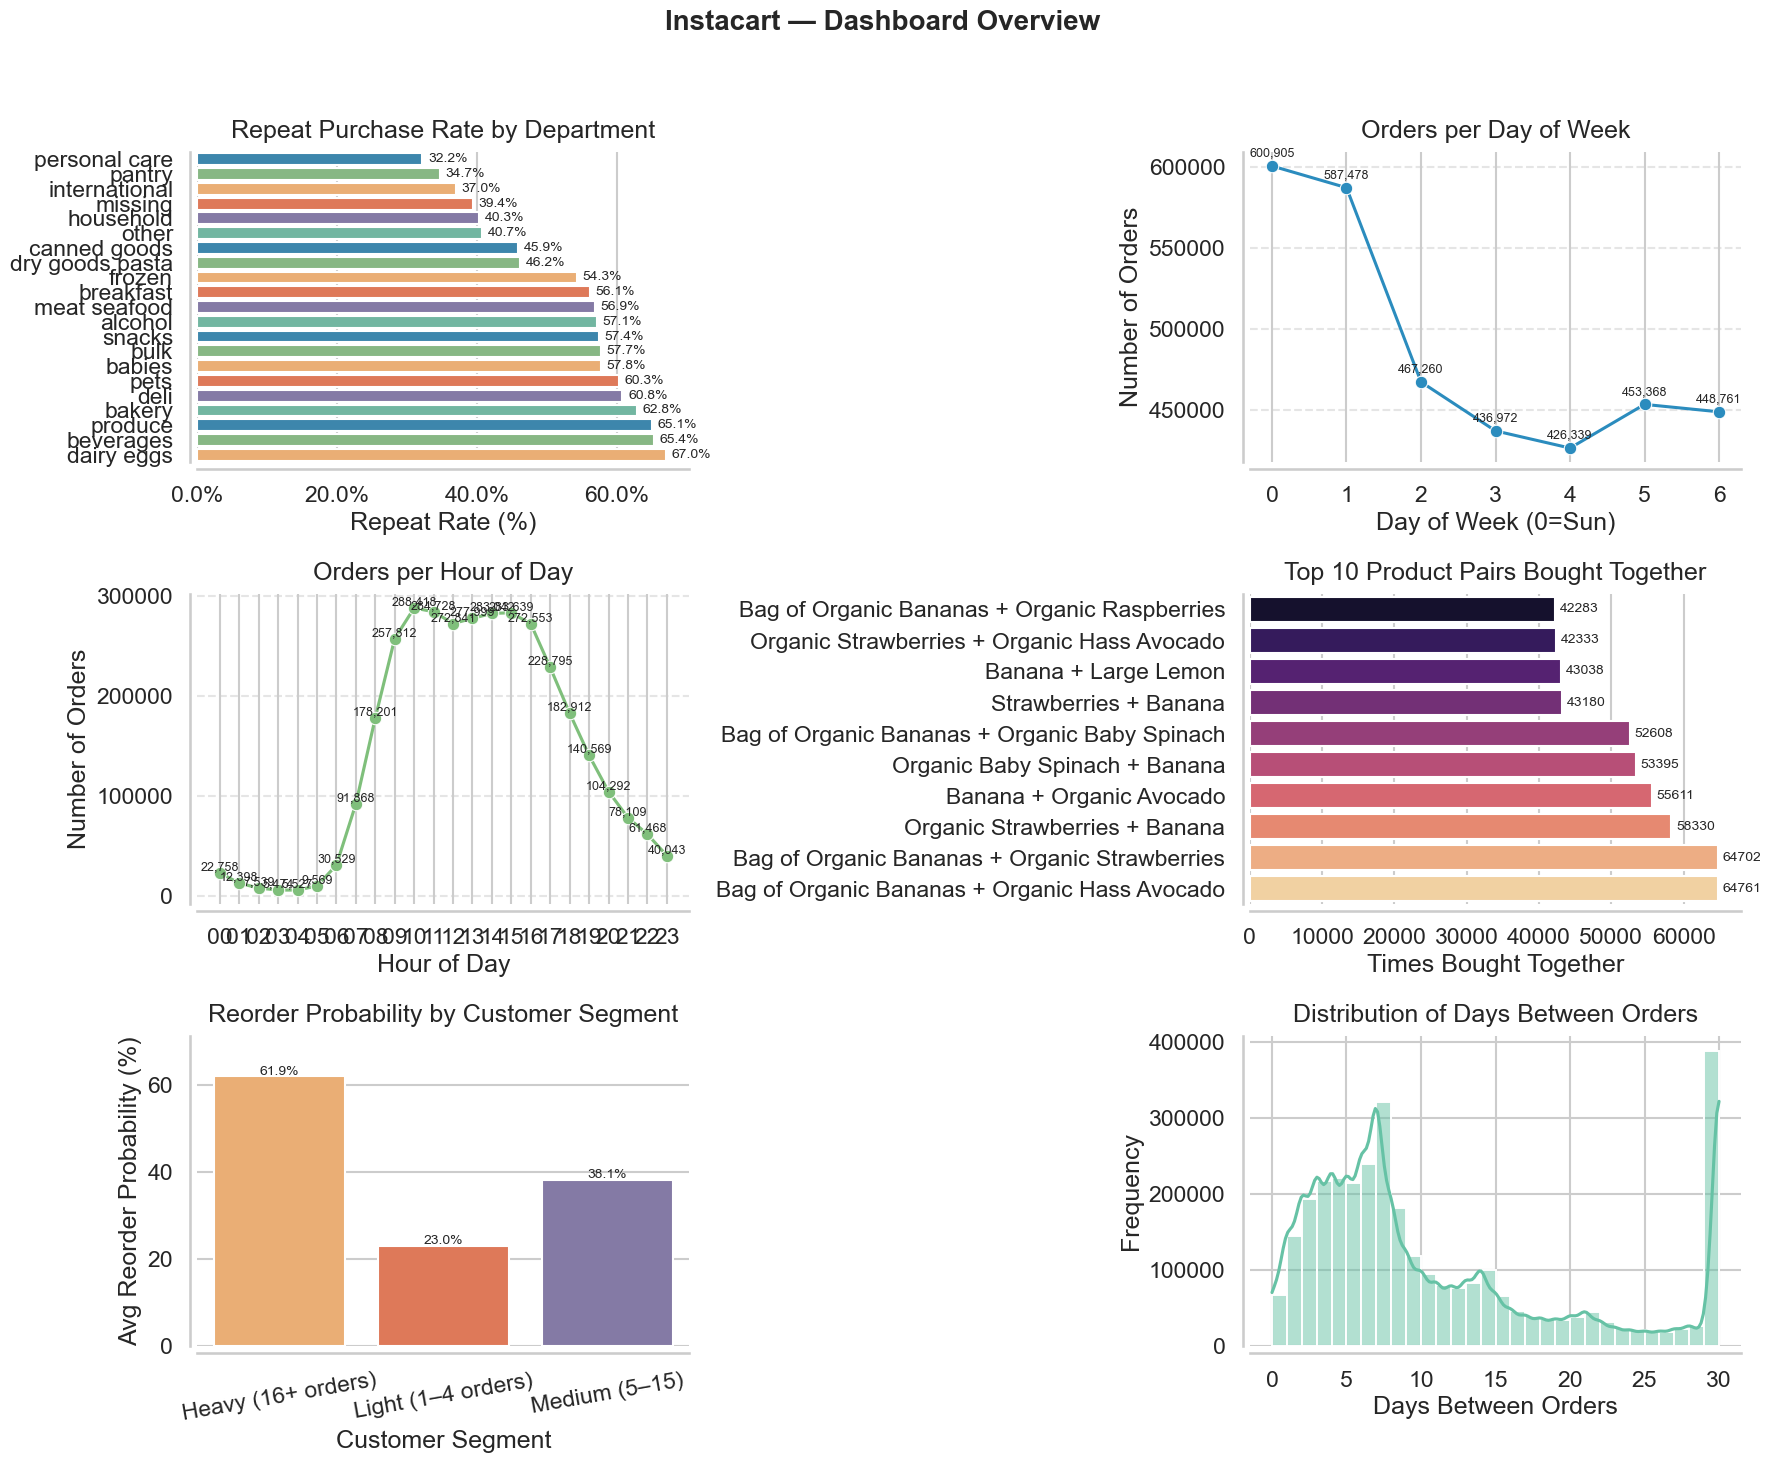

In [80]:
# Polished 2x3 dashboard: improved colors, labels, and annotations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme(style="whitegrid")
sns.set_context("talk")
PALETTE = sns.color_palette(["#2b8cbe", "#7fbf7b", "#fdae61", "#f46d43", "#8073ac", "#66c2a5"])

def bulk_load_data():
    # --- Data (same queries as before) ---
    df_repeat_dept = con.sql("""
SELECT 
    d.department,
    AVG(op.reordered)::DOUBLE AS repeat_rate
FROM final_instacart_db.fact_order_products op
JOIN final_instacart_db.dim_product p ON op.product_id = p.product_id
JOIN final_instacart_db.dim_department d ON p.department_id = d.department_id
GROUP BY d.department
ORDER BY repeat_rate DESC;
""").df()

    df_dow = con.sql("""
SELECT order_dow, COUNT(*) AS n_orders
FROM final_instacart_db.dim_order
GROUP BY order_dow
ORDER BY order_dow;
""").df()

    df_hour = con.sql("""
SELECT order_hour_of_day, COUNT(*) AS n_orders
FROM final_instacart_db.dim_order
GROUP BY order_hour_of_day
ORDER BY order_hour_of_day;
""").df()

    # create helper views used by the pairs query
    con.sql("""
CREATE OR REPLACE VIEW final_instacart_db.top_products AS
SELECT product_id, COUNT(*) AS times_ordered
FROM final_instacart_db.fact_order_products
GROUP BY product_id
ORDER BY times_ordered DESC
LIMIT 200;
""")
    con.sql("""
CREATE OR REPLACE VIEW final_instacart_db.op_top AS
SELECT op.*
FROM final_instacart_db.fact_order_products op
JOIN final_instacart_db.top_products t USING (product_id);
""")

    df_pairs = con.sql("""
WITH pairs AS (
    SELECT a.order_id, a.product_id AS product_a, b.product_id AS product_b
    FROM final_instacart_db.op_top a
    JOIN final_instacart_db.op_top b
      ON a.order_id = b.order_id
     AND a.product_id < b.product_id
)
SELECT
    p1.product_name AS product_a_name,
    p2.product_name AS product_b_name,
    COUNT(*) AS times_bought_together
FROM pairs
JOIN final_instacart_db.dim_product p1 ON p1.product_id = pairs.product_a
JOIN final_instacart_db.dim_product p2 ON p2.product_id = pairs.product_b
GROUP BY p1.product_name, p2.product_name
ORDER BY times_bought_together DESC
LIMIT 10;
""").df()

    if not df_pairs.empty:
        df_pairs["pair"] = df_pairs["product_a_name"] + " + " + df_pairs["product_b_name"]
    else:
        df_pairs = pd.DataFrame(columns=["pair", "times_bought_together"])

    df_segments = con.sql("""
WITH user_orders AS (
    SELECT user_id, COUNT(*) AS order_count
    FROM final_instacart_db.dim_order
    GROUP BY user_id
),
reorder_stats AS (
    SELECT o.user_id, AVG(op.reordered)::DOUBLE AS reorder_prob
    FROM final_instacart_db.dim_order o
    JOIN final_instacart_db.fact_order_products op ON o.order_id = op.order_id
    GROUP BY o.user_id
)
SELECT 
    CASE 
        WHEN u.order_count < 5 THEN 'Light (1–4 orders)'
        WHEN u.order_count BETWEEN 5 AND 15 THEN 'Medium (5–15)'
        ELSE 'Heavy (16+ orders)'
    END AS segment,
    AVG(r.reorder_prob) AS avg_reorder_probability
FROM user_orders u
JOIN reorder_stats r ON u.user_id = r.user_id
GROUP BY segment
ORDER BY segment;
""").df()

    df_days = con.sql("""
SELECT days_since_prior_order AS days_between_orders
FROM final_instacart_db.dim_order
WHERE days_since_prior_order IS NOT NULL;
""").df()

    # --- Prepare data for plotting ---
    if "repeat_rate" in df_repeat_dept.columns and not df_repeat_dept.empty:
        df_repeat_dept = df_repeat_dept.copy()
        df_repeat_dept["repeat_pct"] = df_repeat_dept["repeat_rate"] * 100
        df_repeat_dept = df_repeat_dept.sort_values("repeat_pct", ascending=True)

    df_pairs_plot = df_pairs.sort_values("times_bought_together", ascending=True)

    # --- Figure ---
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    (ax1, ax2), (ax3, ax4), (ax5, ax6) = axes
    fig.suptitle("Instacart — Dashboard Overview", fontsize=20, fontweight="bold")

    # Plot 1: Repeat rate by department (horizontal bar, percent labels)
    if not df_repeat_dept.empty:
        sns.barplot(
            data=df_repeat_dept,
            x="repeat_pct",
            y="department",
            ax=ax1,
            hue="department",  # Assign hue to the same variable as y
            palette=PALETTE[: len(df_repeat_dept)],
            legend=False  # Disable legend
        )

        ax1.set_title("Repeat Purchase Rate by Department", pad=10)
        ax1.set_xlabel("Repeat Rate (%)")
        ax1.set_ylabel("")
        ax1.xaxis.set_major_formatter(lambda x, pos: f"{x:.1f}%")
        for p in ax1.patches:
            width = p.get_width()
            ax1.text(width + 0.8, p.get_y() + p.get_height() / 2, f"{width:.1f}%", va="center", fontsize=10)
    else:
        ax1.text(0.5, 0.5, "No data available", ha="center", va="center")

    # Plot 2: Orders per day of week (line with markers)
    if not df_dow.empty:
        sns.lineplot(data=df_dow, x="order_dow", y="n_orders", marker="o", ax=ax2, color=PALETTE[0], linewidth=2.2)
        ax2.set_title("Orders per Day of Week", pad=10)
        ax2.set_xlabel("Day of Week (0=Sun)")
        ax2.set_ylabel("Number of Orders")
        ax2.grid(axis="y", linestyle="--", alpha=0.5)
        # annotate points
        for x, y in zip(df_dow["order_dow"], df_dow["n_orders"]):
            ax2.text(x, y + max(df_dow["n_orders"].max() * 0.01, 1), f"{int(y):,}", ha="center", fontsize=9)
    else:
        ax2.text(0.5, 0.5, "No data available", ha="center", va="center")

    # Plot 3: Orders per hour of day (line)
    if not df_hour.empty:
        sns.lineplot(data=df_hour, x="order_hour_of_day", y="n_orders", marker="o", ax=ax3, color=PALETTE[1])
        ax3.set_title("Orders per Hour of Day", pad=10)
        ax3.set_xlabel("Hour of Day")
        ax3.set_ylabel("Number of Orders")
        ax3.grid(axis="y", linestyle="--", alpha=0.5)
        for x, y in zip(df_hour["order_hour_of_day"], df_hour["n_orders"]):
            ax3.text(x, y + max(df_hour["n_orders"].max() * 0.01, 1), f"{int(y):,}", ha="center", fontsize=9)
    else:
        ax3.text(0.5, 0.5, "No data available", ha="center", va="center")

    # Plot 4: Top product pairs bought together (horizontal bar)
    if not df_pairs_plot.empty:
        sns.barplot(data=df_pairs_plot, x="times_bought_together", y="pair", ax=ax4, palette="magma")
        ax4.set_title("Top 10 Product Pairs Bought Together", pad=10)
        ax4.set_xlabel("Times Bought Together")
        ax4.set_ylabel("")
        max_w = df_pairs_plot["times_bought_together"].max() if not df_pairs_plot.empty else 1
        for p in ax4.patches:
            w = p.get_width()
            ax4.text(w + max(max_w * 0.01, 0.5), p.get_y() + p.get_height() / 2, f"{int(w)}", va="center", fontsize=10)
    else:
        ax4.text(0.5, 0.5, "No frequent pairs found", ha="center", va="center")

    # Plot 5: Reorder probability by segment (bar with percentage)
    if not df_segments.empty:
        df_segments_plot = df_segments.copy()
        df_segments_plot["avg_reorder_pct"] = df_segments_plot["avg_reorder_probability"] * 100
        sns.barplot(
            data=df_segments_plot,
            x="segment",
            y="avg_reorder_pct",
            ax=ax5,
            palette=PALETTE[2:5]
        )
        ax5.set_title("Reorder Probability by Customer Segment", pad=10)
        ax5.set_xlabel("Customer Segment")
        ax5.set_ylabel("Avg Reorder Probability (%)")
        ax5.set_ylim(0, max(10, df_segments_plot["avg_reorder_pct"].max() * 1.15))
        for p in ax5.patches:
            h = p.get_height()
            ax5.text(p.get_x() + p.get_width() / 2, h + 0.4, f"{h:.1f}%", ha="center", fontsize=10)
        ax5.tick_params(axis="x", rotation=10)
    else:
        ax5.text(0.5, 0.5, "No segment data", ha="center", va="center")

    # Plot 6: Distribution of days between orders (hist + KDE)
    if not df_days.empty and "days_between_orders" in df_days.columns:
        sns.histplot(df_days["days_between_orders"].dropna(), bins=30, kde=True, color=PALETTE[5], ax=ax6)
        ax6.set_title("Distribution of Days Between Orders", pad=10)
        ax6.set_xlabel("Days Between Orders")
        ax6.set_ylabel("Frequency")
    else:
        ax6.text(0.5, 0.5, "No days-between-orders data", ha="center", va="center")

    # Final polish
    for ax in axes.flatten():
        sns.despine(ax=ax, offset=5)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Render dashboard
bulk_load_data()

## 7. Business Analytical and Inference Questions

This analysis investigates whether a customer’s next order date can be predicted using their historical shopping behavior. The dependent variable, days_since_prior_order, represents the number of days between consecutive purchases. Several behavioral features such as the user’s average ordering gap, typical basket size, preferred ordering time, overall order frequency, weekend shopping habits, and reorder tendencies—are used as predictors.

- Analytical Questions

    - Q1. Customer loyalty and product performance

    - Q2. Demand over time and staff scheduling

    - Q3. Products that are purchased together (cross-selling)

    - Q4. Customer segments and repurchase behavior

- Model Prediction Questions

    - Q5.1. Predict how many days a customer will wait before placing their next order

    - Q5.2. What factors influence how many items a customer will purchase in their next order?

    - Q5.3. What drives customers to add certain products earlier in their shopping session, and how do user habits and product familiarity influence add-to-cart order?



### 7.1. Q1. Customer loyalty and product performance

Which products and departments show the highest rates of repeat purchases? What does this tell us about customer loyalty and product performance?

In [81]:
# Which products and departments show the highest rates of repeat purchases?
q1 = """
SELECT
    p.product_name,
    d.department,
    COUNT(*) AS total_orders,
    AVG(CASE WHEN f.reordered = 1 THEN 1.0 ELSE 0.0 END) AS reorder_rate
FROM final_instacart_db.fact_order_products f
JOIN final_instacart_db.dim_product p ON f.product_id = p.product_id
JOIN final_instacart_db.dim_department d ON p.department_id = d.department_id
GROUP BY p.product_name, d.department
HAVING COUNT(*) > 100
ORDER BY total_orders DESC
LIMIT 20;
"""

q1 = con.sql(q1).df()
q1

,product_name,department,total_orders,reorder_rate
0,Banana,produce,491291,0.845051
1,Bag of Organic Bananas,produce,394930,0.833755
2,Organic Strawberries,produce,275577,0.778178
3,Organic Baby Spinach,produce,251705,0.774474
4,Organic Hass Avocado,produce,220877,0.797607
5,Organic Avocado,produce,184224,0.761410
6,Large Lemon,produce,160792,0.697659
7,Strawberries,produce,149445,0.699843
8,Limes,produce,146660,0.681863
9,Organic Whole Milk,dairy eggs,142813,0.831045


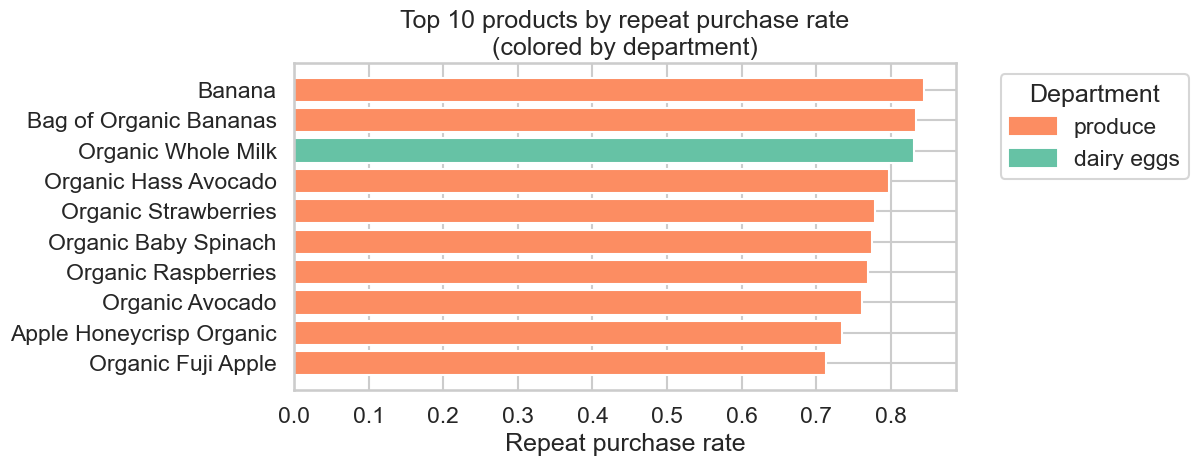

In [82]:
q1_plot = q1.sort_values("reorder_rate", ascending=False).head(10)

# 1. Convert the "department" column to a categorical type to assign a different color to each department
departments = q1_plot["department"].astype("category")

# 2. Convert each category into a numeric code to pick colors from the colormap
codes = departments.cat.codes

# 3. Select a categorical colormap (tab20) provides 10 well-contrasted colors, good for categories.
cmap = plt.get_cmap("Set2")

# 4. Assign a color to each product based on its department code
colors = [cmap(c) for c in codes]

# 5. Create the horizontal bar chart
plt.figure(figsize=(10, 5))

# Each bar represents a product and its repeat purchase rate,
# and is colored according to its department.
plt.barh(q1_plot["product_name"], q1_plot["reorder_rate"], color=colors)

# Invert the Y-axis so the product with the highest reorder_rate appears on top
plt.gca().invert_yaxis()

# Axis label and title
plt.xlabel("Repeat purchase rate")
plt.title("Top 10 products by repeat purchase rate\n(colored by department)")

# Automatically adjust layout to avoid label cut-offs
plt.tight_layout()

# 6. Build the legend manually:

legend_patches = []
# zip(departments, codes) pairs each department with its numeric code
for dept, code in dict(zip(departments, codes)).items(): # dict(...) removes duplicates because dictionary keys (departments) must be unique
    legend_patches.append(mpatches.Patch(color=cmap(code), label=dept))

# Show the legend outside the plot area
plt.legend(
    handles=legend_patches,
    title="Department",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

# Display the plot
plt.show()

The analysis of repurchase rates shows that Instacart customers exhibit strong loyalty to certain products such as Chocolate Love Bar, Maca Buttercups, Benchbreak Chardonnay and Fragrance Free Clay, among others, which have repurchase rates exceeding 90%. This indicates that these products are highly preferred for repeat purchases.

A significant portion of the products with a high probability of repurchase belong to the Snacks, Alcohol, and Pet Supplies departments, with repurchase rates of over 85%.

These results suggest that these products are key to customer loyalty and recurring revenue. Maintaining high availability is crucial, as stockouts would directly impact loyal customers.

These products can be used in promotions with different brands. Additionally, other items from departments with high repurchase rates can be selected to promote them and boost new brands. The app could also offer quick "buy again" options or specific promotions for these products.


### 7.2. Q2. Demand over time and staff scheduling

What are the busiest times for orders, based on the day of the week and time of day? How can these patterns help with staff planning and operational efficiency?

In [83]:
q2_day = """
SELECT 
    o.order_dow AS day_of_week,
    CASE 
        WHEN o.order_dow = 0 THEN 'Sunday'
        WHEN o.order_dow = 1 THEN 'Monday'
        WHEN o.order_dow = 2 THEN 'Tuesday'
        WHEN o.order_dow = 3 THEN 'Wednesday'
        WHEN o.order_dow = 4 THEN 'Thursday'
        WHEN o.order_dow = 5 THEN 'Friday'
        WHEN o.order_dow = 6 THEN 'Saturday'
    END AS day_name,
    COUNT(*) AS total_items
FROM final_instacart_db.fact_order_products f
JOIN final_instacart_db.dim_order o 
    ON f.order_id = o.order_id
GROUP BY o.order_dow
ORDER BY o.order_dow;
"""

q2_day = con.sql(q2_day).df()
q2_day


,day_of_week,day_name,total_items
0,0,Sunday,6533692
1,1,Monday,5871834
2,2,Tuesday,4378360
3,3,Wednesday,3998498
4,4,Thursday,3942696
5,5,Friday,4386443
6,6,Saturday,4707583


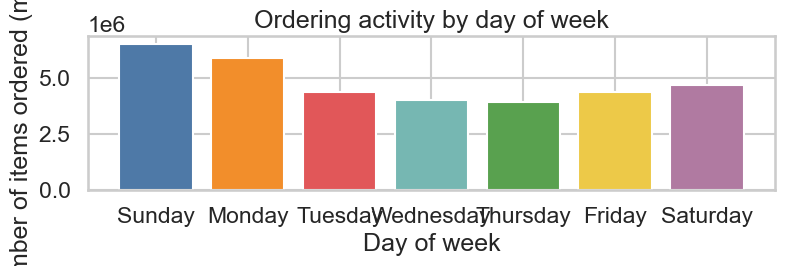

In [84]:
colors = ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F", "#EDC948", "#B07AA1"]

plt.figure(figsize=(8, 3))
plt.bar(q2_day["day_name"], q2_day["total_items"], color=colors)
plt.xlabel("Day of week")
plt.ylabel("Number of items ordered (millions)")
plt.title("Ordering activity by day of week")
plt.tight_layout()
plt.show()


The analysis by day of the week shows that the days with the highest activity are around the weekend: Sunday, Saturday, and Monday, with approximately six, five, and four million items ordered, respectively. However, activity decreases between Tuesday and Thursday, reaching its lowest level on Thursday, and begins to increase again on Friday. This pattern suggests that the Instacart app experiences the highest ordering activity on weekends and Mondays.

In [85]:
q2_hour_sql = """
SELECT
    o.order_hour_of_day AS hour_of_day,
    COUNT(*) AS total_items
FROM final_instacart_db.fact_order_products f
JOIN final_instacart_db.dim_order o ON f.order_id = o.order_id
GROUP BY o.order_hour_of_day
ORDER BY o.order_hour_of_day;
"""

q2_hour_df = con.sql(q2_hour_sql).df()
q2_hour_df


,hour_of_day,total_items
0,00,228031
1,01,121412
2,02,72660
3,03,53759
4,04,55714
5,05,91909
6,06,302642
7,07,928239
8,08,1787359
9,09,2550569


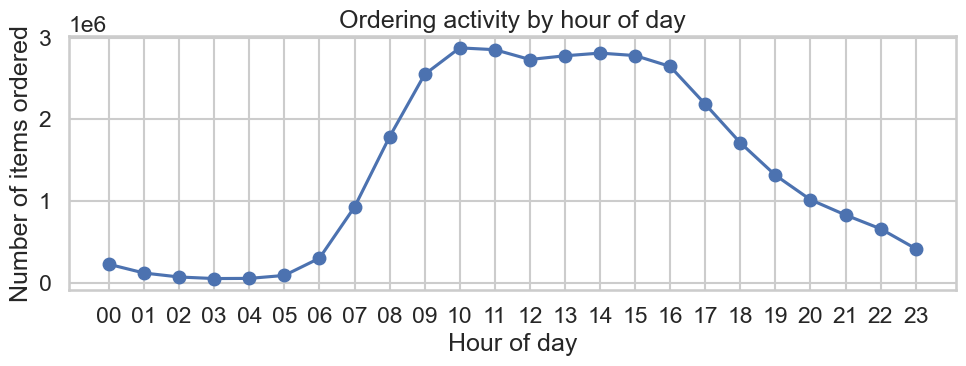

In [86]:
plt.figure(figsize=(10, 4))
plt.plot(q2_hour_df["hour_of_day"], q2_hour_df["total_items"], marker="o")
plt.xlabel("Hour of day")
plt.ylabel("Number of items ordered")
plt.title("Ordering activity by hour of day")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


The graph reveals that the highest volume of orders is concentrated in the late morning and early afternoon. The following pattern is observed: during the early morning hours, from 0:00 to 5:00, activity is very low. Demand begins to increase around 7:00 to 9:00, reaches a broad peak between 10:00 and 15:00, and then gradually decreases from 16:00 onwards.

These results indicate the times when the application needs to have the best capacity to ensure optimal performance, as it experiences the highest load and also to efficiently connect with buyers for deliveries.

During the mid-week periods (Wednesday and Thursday) and the early morning hours, when demand is low, maintenance activities can be performed on the application and training can be provided to buyers. Similarly, during periods of high demand, the maximum number of staff should be available for customer support and real-time monitoring to prevent customer issues and delivery delays.

### 7.3. Q3. Products that are purchased together (cross-selling)

What products are most frequently purchased together? How can these preferences be used to design cross-selling opportunities or recommendations?

In [87]:
q3_sql = """
WITH top_products AS (
    SELECT
        product_id,
        COUNT(*) AS total_items
    FROM final_instacart_db.fact_order_products
    GROUP BY product_id
    ORDER BY total_items DESC
    LIMIT 100          -- trabajamos solo con los 100 más vendidos
),
filtered AS (
    SELECT
        f.order_id,
        f.product_id
    FROM final_instacart_db.fact_order_products f
    JOIN final_instacart_db.top_products t USING (product_id)
)
SELECT
    p1.product_name AS product_A,
    p2.product_name AS product_B,
    COUNT(*) AS times_bought_together
FROM filtered f1
JOIN filtered f2
      ON f1.order_id = f2.order_id
     AND f1.product_id < f2.product_id
JOIN final_instacart_db.dim_product p1 ON f1.product_id = p1.product_id
JOIN final_instacart_db.dim_product p2 ON f2.product_id = p2.product_id
GROUP BY product_A, product_B
ORDER BY times_bought_together DESC
LIMIT 20;
"""

q3_df = con.sql(q3_sql).df()
q3_df


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,product_A,product_B,times_bought_together
0,Bag of Organic Bananas,Organic Hass Avocado,64761
1,Bag of Organic Bananas,Organic Strawberries,64702
2,Organic Strawberries,Banana,58330
3,Banana,Organic Avocado,55611
4,Organic Baby Spinach,Banana,53395
5,Bag of Organic Bananas,Organic Baby Spinach,52608
6,Strawberries,Banana,43180
7,Banana,Large Lemon,43038
8,Organic Strawberries,Organic Hass Avocado,42333
9,Bag of Organic Bananas,Organic Raspberries,42283


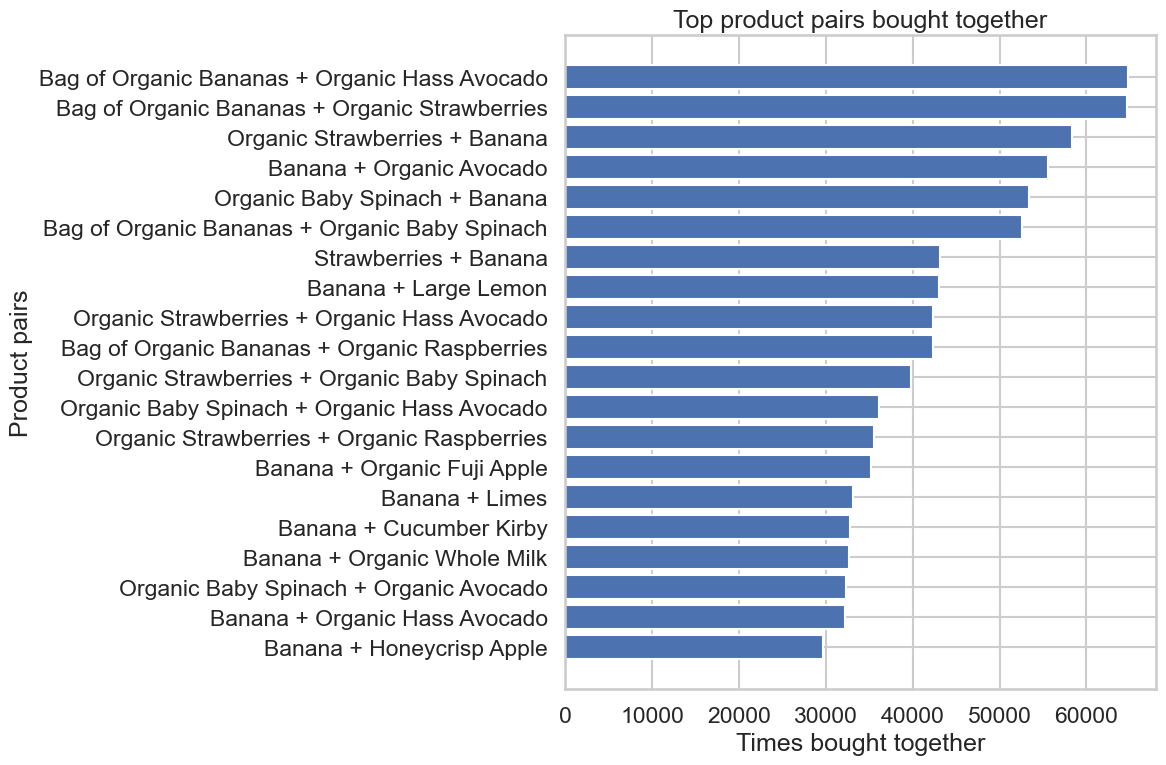

In [88]:
top_pairs = q3_df.copy()
top_pairs['pair'] = top_pairs['product_A'] + " + " + top_pairs['product_B']

plt.figure(figsize=(12, 8))
plt.barh(top_pairs['pair'], top_pairs['times_bought_together'])
plt.xlabel("Times bought together")
plt.ylabel("Product pairs")
plt.title("Top product pairs bought together")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The results show very defined co-purchasing patterns, especially within the fruits and vegetables category. The most frequent pairings include combinations such as bananas with avocados, strawberries, spinach, and lemons, among other fresh produce.

It's noteworthy that bananas appear in almost all of the top pairings, confirming that they are one of the most frequently purchased and combined products on Instacart.  Bananas are a product that consumers add to their carts very often and that also serves as a base for other combinations.

These findings suggest that the app could display automatic recommendations for complementary products when an item is added to the cart, in order to encourage cross-selling. Furthermore, the most frequent combinations provide an excellent basis for designing attractive offers or bundles aligned with users' actual purchasing habits.

### 7.4. Q4. Customer segments and repurchase behavior

How does repurchase behavior and the time between orders vary across different customer segments? What factors influence this pattern?

In [89]:
q4_sql = """
WITH customer_stats AS (
    SELECT user_id, AVG(days_since_prior_order) AS avg_days_between_orders, COUNT(order_id) AS total_orders
    FROM final_instacart_db.dim_order
    WHERE days_since_prior_order IS NOT NULL
    GROUP BY user_id
),
segments AS (
    SELECT
        user_id, avg_days_between_orders, total_orders,
        CASE
            WHEN avg_days_between_orders <= 7 THEN 'High-frequency'
            WHEN avg_days_between_orders BETWEEN 8 AND 20 THEN 'Medium-frequency'
            ELSE 'Low-frequency'
        END AS customer_segment
    FROM customer_stats
)
SELECT
    s.customer_segment, COUNT(DISTINCT s.user_id) AS num_customers, AVG(f.reordered) AS avg_reorder_rate,
    AVG(s.avg_days_between_orders) AS avg_days_between_orders
FROM segments s
JOIN final_instacart_db.dim_order o             ON o.user_id = s.user_id
JOIN final_instacart_db.fact_order_products f   ON f.order_id = o.order_id
GROUP BY s.customer_segment
ORDER BY avg_reorder_rate DESC;
"""

q4_df = con.sql(q4_sql).df()
q4_df


,customer_segment,num_customers,avg_reorder_rate,avg_days_between_orders
0,High-frequency,24471,0.711045,5.061925
1,Medium-frequency,116876,0.554622,12.752927
2,Low-frequency,64862,0.509999,16.629922


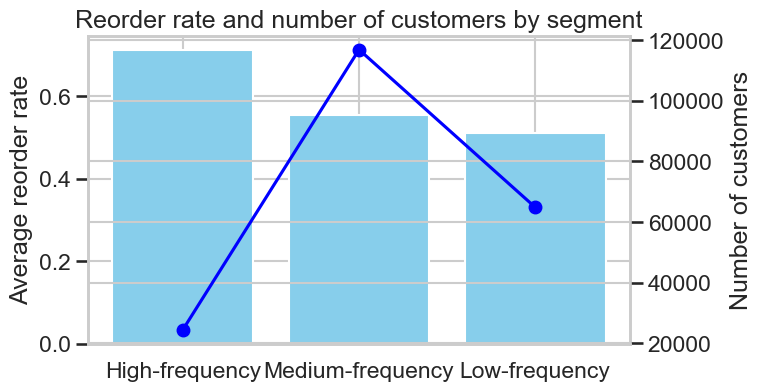

In [90]:
fig, ax1 = plt.subplots(figsize=(7, 4))

# for reorder rate 
ax1.bar(q4_df["customer_segment"], q4_df["avg_reorder_rate"], color="skyblue")
ax1.set_ylabel("Average reorder rate")

# for number of customer
ax2 = ax1.twinx()
ax2.plot(q4_df["customer_segment"], q4_df["num_customers"], color="blue", marker="o")
ax2.set_ylabel("Number of customers")

plt.title("Reorder rate and number of customers by segment")
plt.show()



Customers were grouped into three segments based on their average number of days between orders. High-frequency buyers place a new order approximately every 5 days, medium-frequency buyers every 13 days, and low-frequency buyers every 16 days on average.

The graph shows a clear relationship between purchase frequency and repurchase rate. The high-frequency segment has the highest average repurchase rate (71%), indicating that most of the items in their orders are products they have purchased before. This means that these customers, although smaller in number, rely on recurring products and constitute the most loyal and predictable group. In contrast, the medium and low frequency segments show lower repurchase rates (around 55% and 51%, respectively), suggesting that their purchases are more occasional and less routine.

The high-frequency segment is valuable because they purchase very regularly and repurchase most of their products. They are ideal candidates for "buy again" shortcuts, automatic subscription renewals with discounts, or loyalty programs. For the medium and low frequency segments, the app can offer reminders of past purchases or promotions to encourage more regular buying behavior and increase their repurchase rates.

### 7.5. Q5.1. Predict how many days a customer will wait before placing their next order 

- Can we predict how many days a customer will wait before placing their next order, based on their shopping behavior and ordering patterns?

The goal of this model is to understand which behavioral patterns most strongly influence reorder timing and to generate a data-driven estimate of when a customer is likely to return. This insight is valuable for Instacart’s customer engagement, personalized marketing, and inventory planning.



In [91]:
df_next_order = con.sql("""
SELECT
    user_id,
    order_number,
    days_since_prior_order,
    
    -- Past average gap for user
    AVG(days_since_prior_order) OVER (PARTITION BY user_id ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING)
        AS user_avg_gap,
    
    -- Basket size as a behavioral signal
    (SELECT COUNT(*) FROM final_instacart_db.fact_order_products op WHERE op.order_id = o.order_id)
        AS basket_size,
        
    order_dow,
    order_hour_of_day
FROM final_instacart_db.dim_order o
WHERE days_since_prior_order IS NOT NULL;
""").df()

In [92]:
df_user_features = con.sql("""
    WITH user_orders AS (
        SELECT
            user_id,
            order_id,
            order_number,
            order_dow,
            days_since_prior_order
        FROM final_instacart_db.dim_order
        WHERE eval_set = 'prior'
    ),
    order_items AS (
        SELECT
            u.user_id,
            u.order_id,
            COUNT(*) AS basket_size,
            SUM(CASE WHEN p.reordered = 1 THEN 1 ELSE 0 END)::DOUBLE
                / COUNT(*) AS reorder_rate
        FROM user_orders u
        JOIN final_instacart_db.fact_order_products p
            USING(order_id)
        GROUP BY u.user_id, u.order_id
    ),
    user_summary AS (
        SELECT
            u.user_id,
            COUNT(DISTINCT u.order_id)                 AS user_total_orders,
            AVG(oi.basket_size)                        AS user_avg_basket_size,
            AVG(oi.reorder_rate)                       AS user_reorder_ratio,
            STDDEV(u.days_since_prior_order)           AS user_order_std
        FROM user_orders u
        JOIN order_items oi
            USING(user_id, order_id)
        GROUP BY u.user_id
    ),
    weekend_flag AS (
        SELECT
            user_id,
            MAX(CASE WHEN order_dow IN (0,6) THEN 1 ELSE 0 END) AS is_weekend
        FROM user_orders
        GROUP BY user_id
    )
    SELECT 
        u.user_id,
        u.user_total_orders,
        u.user_avg_basket_size,
        u.user_reorder_ratio,
        u.user_order_std,
        w.is_weekend
    FROM user_summary u
    LEFT JOIN weekend_flag w USING(user_id)
""").df()

df_user_features.head()

,user_id,user_total_orders,user_avg_basket_size,user_reorder_ratio,user_order_std,is_weekend
0,9513,99,8.636364,0.870947,2.195763,1
1,74880,8,8.875000,0.307937,9.727232,1
2,190436,4,11.000000,0.404221,12.288206,1
3,148895,27,10.370370,0.546616,8.427428,1
4,173874,12,15.000000,0.617683,5.391913,1


In [93]:
df_next_order = df_next_order.merge(
    df_user_features,
    on="user_id",
    how="left"
)

df_next_order.columns.tolist()

df = duckdb.sql("SELECT * FROM df_next_order").df()
df.head()

,user_id,order_number,days_since_prior_order,user_avg_gap,basket_size,order_dow,order_hour_of_day,user_total_orders,user_avg_basket_size,user_reorder_ratio,user_order_std,is_weekend
0,58892,20,17.0,9.937500,2,3,23,36,4.305556,0.649998,7.366743,1
1,58892,27,6.0,10.151515,2,6,16,36,4.305556,0.649998,7.366743,1
2,58892,31,7.0,10.029412,2,5,16,36,4.305556,0.649998,7.366743,1
3,58892,18,7.0,9.942857,1,6,08,36,4.305556,0.649998,7.366743,1
4,58967,5,14.0,NaN,4,2,17,12,3.083333,0.350198,9.571739,1


In [94]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

numeric_features = [
    "user_avg_gap",
    "basket_size",
    "order_dow",
    "order_hour_of_day",
    "user_total_orders",
    "user_avg_basket_size",
    "user_reorder_ratio",
    "user_order_std",
    "is_weekend",
]

target = "days_since_prior_order"


model_cols = numeric_features + [target]
df_model = df_next_order[model_cols].copy()

df_model["is_weekend"] = df_model["is_weekend"].astype(int)

df_model = df_model.replace([np.inf, -np.inf], np.nan)


# Drop any rows with NaN in any model column
df_model = df_model.dropna()

# Define X and y as float
X = df_model[numeric_features].astype(float)
y = df_model[target].astype(float)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Add constant
X_train_const = sm.add_constant(X_train)
X_test_const  = sm.add_constant(X_test)

# Fit OLS on training data
model = sm.OLS(y_train, X_train_const).fit()
print(model.summary())

# Predict on test set
y_pred = model.predict(X_test_const)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("\n----------------------------")
print("MODEL PERFORMANCE METRICS")
print("----------------------------")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Train R² (from OLS): {model.rsquared:.4f}")
print(f"Train Adjusted R²: {model.rsquared_adj:.4f}")
print(f"Test R² (holdout set): {test_r2:.4f}")

                              OLS Regression Results                              
Dep. Variable:     days_since_prior_order   R-squared:                       0.319
Model:                                OLS   Adj. R-squared:                  0.319
Method:                     Least Squares   F-statistic:                 1.253e+05
Date:                    Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                            13:00:41   Log-Likelihood:            -8.2528e+06
No. Observations:                 2406932   AIC:                         1.651e+07
Df Residuals:                     2406922   BIC:                         1.651e+07
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

### Constant: 9.7340
-If all predictors were zero (baseline customer), the expected reorder gap is ~9.73 days.
-This is the model’s starting point before adjustments from each variable.
### Dependent variable
`days_since_prior_order` :
- This is the number of days between the user’s previous order and their current order.
- Why I selected it:
-It directly represents the behavior we want to predict:
“How many days until the user places their next order?”

### Independent variables
`users_avg_gap`: 

Why we use it:
- The strongest indicator of future behavior is past behavior.
- Customers who usually wait longer between orders tend to continue that pattern.
- This feature captures the shopper’s habitual order cycle.
- Coefficient: 0.4602
- For every 1-day increase in a customer’s historical average order gap,
their next order is predicted to take 0.46 days longer.
- Customers who historically wait longer tend to continue waiting longer.
- This variable captures habitual ordering patterns.
Expected prediction:
- Positive → Higher average gap means they will wait longer for the next order.
                                                            
- `basket_size`:

Why we use it:
- Users with large baskets may stock up, leading to longer gaps before their next order.
- Small-basket users reorder more frequently.
- This variable reflects short-term purchasing needs.
- Coefficient: 0.0559
- For every 1 additional item added to the basket,
next order is 0.056 days later (~1.3 hours).
- Bigger baskets → slightly longer time until next purchase. Maybe because people stocked up more.

- `order_dow`:

Why we use it:
- Ordering behavior varies across weekdays and weekends.
- People may shop more on certain days due to schedules, pay cycles, or promotions.
- This captures weekly purchasing rhythms.
- Coefficient: –0.0719
- For each increase in day index (Monday=0 → Sunday=6):
- reorder time decreases by 0.07 days (~1.7 hours).
- Customers ordering later in the week tend to reorder slightly sooner.

- `order_hour_of_day`:

Why we use it:
- Ordering time reflects daily patterns: morning shoppers vs. evening shoppers.
- Time of day can signal user routines and urgency.
- This helps model daily shopping behaviors.
- Coefficient: –0.0450
- For every 1-hour increase in the order time (e.g., 10 AM → 11 AM):
reorder time decreases by 0.045 days (~1.1 hours).

- `user_total_orders`

Why we use it:
- More experienced shoppers tend to order more consistently and frequently.
- New or inactive users behave differently than loyal users.
- This variable captures long-term engagement with Instacart.
- Coefficient: –0.0717
- Every additional order the user has placed historically
reduces the next order gap by 0.07 days (~1.7 hours).

- `user_avg_basket_size`

Why we use it:
- Heavy shoppers buy more items on average and reorder sooner.
- This reflects the user’s overall shopping intensity.
- It improves prediction beyond just last basket size.
- For every 1-unit increase in a user’s average basket size:
reorder time decreases by 0.039 days (~0.94 hours).
- Users who consistently buy more tend to reorder sooner (heavy shoppers).

- `user_reorder_ratio`

Why we use it:
- A high reorder ratio means users buy the same items again and again.
- These customers tend to shop more frequently because their purchases are routine-based.
- This is a strong indicator of future ordering patterns.
- Coefficient: –2.6799
- If a user’s reorder ratio increases by 1 (i.e., 100% reorder behavior):
their time to next order drops by 2.68 days.
- Even a 10% increase drops reorder gap by 0.268 days (~6.4 hours).
- These users are habitual customers and reorder frequently.

- `user_avg_std`

Why we use it:
- Some users reorder predictably; others vary widely.
- High variability makes future orders less predictable.
- This variable captures consistency vs. irregularity of shopping behavior.  
- Coefficient: 0.2075
- Every 1-day increase in the user’s variability in ordering:
increases next order time by 0.21 days (~5 hours).
- Irregular shoppers stay irregular.
                                            
- `is_weekend`(weekend=1, weekday=0)

Why we use it:
- User behavior changes on weekends (more free time, restocking after the week).
- Weekend orders often lead to different reorder patterns.
- This captures a binary behavior shift.
- Coefficient: –0.4467
- If the previous order was placed on a weekend:
the next order is 0.45 days (~11 hours) sooner.
- Weekend shopping boosts reorder frequency.

### OVERALL MODEL PERFORMANCE

- Train R²: 0.328
- Adjusted R²: 0.328
- MAE: 5.668 days

-The model explains 32.8% of the variation in reorder time (very good for behavioral data).
- On average, predictions are within ~5.7 days of actual reorder times.
- No overfitting (train and test R² match).

- The regression results show that several behavioral factors significantly influence how long a user waits before placing their next order. The strongest positive predictor is user_avg_gap (β = 0.4602), meaning customers who historically take longer between orders continue to do so. Conversely, the strongest negative predictor is user_reorder_ratio (β = –2.6799), indicating that users who frequently reorder the same items place new orders much sooner.

Basket size (β = 0.0559) has a small but positive effect, suggesting that larger baskets slightly delay the next order. Timing variables such as order_hour_of_day (β = –0.0450) and order_dow (β = –0.0719) also play modest roles, with later-day or later-week orders associated with faster reordering.

Overall, high-engagement users those with more total orders (β = –0.0717) and larger average basket sizes (β = –0.0392) tend to reorder sooner. Weekend orders (β = –0.4467) also lead to shorter reorder intervals.

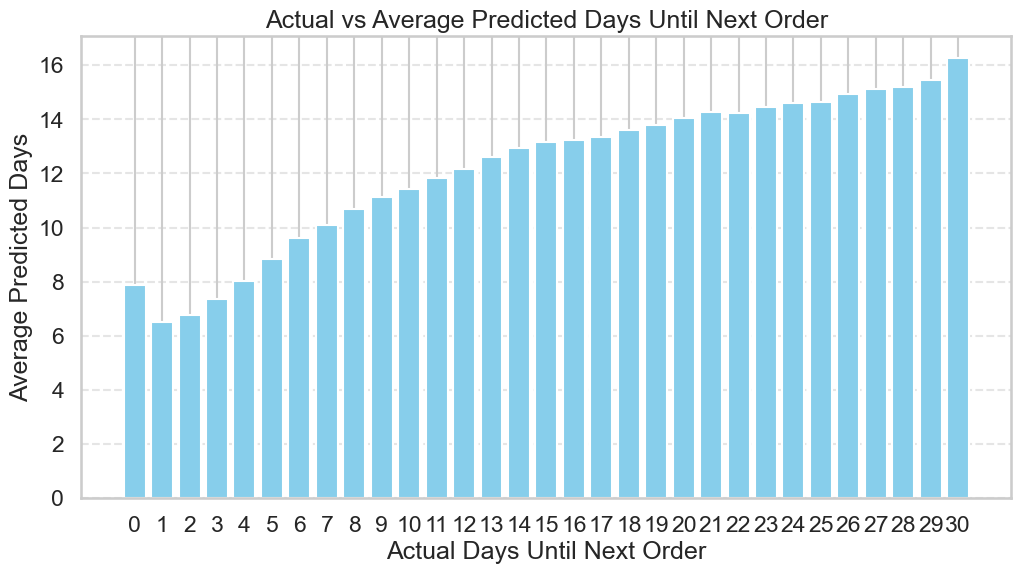

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine actual + predicted into one dataframe
df_results = pd.DataFrame({
    "actual": y_test,
    "predicted": y_pred
})

# Group by actual days and get average prediction
grouped = df_results.groupby("actual")["predicted"].mean()

plt.figure(figsize=(12,6))
plt.bar(grouped.index, grouped.values, color='skyblue')
plt.xlabel("Actual Days Until Next Order")
plt.ylabel("Average Predicted Days")
plt.title("Actual vs Average Predicted Days Until Next Order")
plt.xticks(range(0, 31))  # Show 0 to 30 on x-axis
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [96]:
# Create a table with actual and predicted values
results_table = df_next_order[[
    "user_id",
    "days_since_prior_order"
]].copy()

results_table["predicted_days"] = model.fittedvalues  # or model.predict(X_const)

# Round values for neat display
results_table["predicted_days"] = results_table["predicted_days"].round(2)
results_table["days_since_prior_order"] = results_table["days_since_prior_order"].round(2)

# Show first 20 rows
results_table.head(20)

,user_id,days_since_prior_order,predicted_days
0,58892,17.0,9.62
1,58892,6.0,NaN
2,58892,7.0,9.85
3,58892,7.0,10.01
4,58967,14.0,NaN
5,58967,12.0,15.01
6,58967,30.0,NaN
7,58967,30.0,16.97
8,58967,30.0,17.94
9,58967,10.0,19.17


### 7.6. Q5.2. What factors influence how many items a customer will purchase in their next order?

- Can we predict their next basket size using historical shopping behavior?

The objective of this analysis is to determine which behavioral and temporal factors most strongly predict future basket size. Specifically, we aim to forecast how many items a user will include in their next order based on their past purchase patterns, ordering frequency, and typical shopping behavior.

In [97]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


df_basket = df_next_order.copy()

df_basket = df_basket.sort_values(["user_id", "order_number"])

df_basket["next_basket_size"] = (
    df_basket.groupby("user_id")["basket_size"].shift(-1)
)

df_basket = df_basket.dropna(subset=["next_basket_size"])


predictors = [
    "days_since_prior_order",
    "user_avg_gap",
    "basket_size",            # current order size
    "order_dow",
    "order_hour_of_day",
    "user_total_orders",
    "user_avg_basket_size",
    "user_reorder_ratio",
    "user_order_std",
    "is_weekend"
]

model_df = df_basket[predictors + ["next_basket_size"]].copy()

model_df = model_df.replace([np.inf, -np.inf], np.nan).dropna()

X = model_df[predictors].astype(float)
y = model_df["next_basket_size"].astype(float)

X_const = sm.add_constant(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_const, y, test_size=0.2, random_state=42
)

basket_model = sm.OLS(y_train, X_train).fit()
print(basket_model.summary())

y_pred = basket_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("\n----------------------------")
print("MODEL PERFORMANCE METRICS")
print("----------------------------")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Train R² (from OLS):      {basket_model.rsquared:.4f}")
print(f"Train Adjusted R²:        {basket_model.rsquared_adj:.4f}")
print(f"Test R² (holdout set):    {r2:.4f}")

                            OLS Regression Results                            
Dep. Variable:       next_basket_size   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                 2.347e+05
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:00:44   Log-Likelihood:            -7.0057e+06
No. Observations:             2264322   AIC:                         1.401e+07
Df Residuals:                 2264311   BIC:                         1.401e+07
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

This means the model explains about 45% of the variation in future basket size.
#### Dependent variable
The dependent variable in this model is `next_basket_size`, and the model includes a set of behavioral, historical, and temporal predictors that describe how customers typically shop.

#### Independent Variables

`user_avg_basket_size` (coef = +0.8653)
- The strongest indicator of future basket size, people shop consistently.
- This is the strongest predictor in the model.
- It indicates that customers tend to repeat their usual behavior:
- For every additional item a user typically buys on average,
their next basket increases by ~0.86 items.
- This confirms that basket size is a stable habit-pattern.

`user_reorder_ratio` (coef = +2.3342)
- Routine shoppers have predictable, often larger baskets.
- Customers who reorder the same products frequently tend to buy larger baskets.
- A 1-point increase in reorder ratio increases predicted basket size by 2.33 items.
- This suggests these shoppers have established routines and fill larger carts consistently.

`user_order_std` (coef = +0.1006)
- Captures variability, chaotic shoppers may have large peaks.
- This measures how much a user’s basket sizes fluctuate.
- Higher variability is associated with slightly larger future baskets,
indicating flexible or opportunistic shoppers.

`is_weekend` (coef = +0.3329)
- Weekend shopping tends to be bulkier.
- Weekend orders are 0.33 items larger on average.
- This makes sense: shoppers often buy more when they have time to browse.

`basket_size` (current order size) (coef = +0.0591)
- Current behavior predicts future behavior.
- A slightly larger current basket indicates a slightly larger next basket.
- Although the effect is small, it reflects continuity in shopping behavior.

`user_total_orders` (coef = +0.0064)
- Loyalty and experience usually increase spending.
- More experienced shoppers (with more lifetime orders) tend to buy slightly more items.
- Loyal customers may stock up or do full weekly trips.

`days_since_prior_order` (coef = –0.0298)
- Captures whether a user is a frequent or occasional shopper.
- Longer gaps between orders predict slightly smaller baskets.
- This contradicts the typical assumption of “stock-up shopping,”
and suggests that Instacart users who take long breaks may be light or occasional users.

`user_avg_gap` (coef = –0.0405)
- Measures long-term ordering rhythm.
- Users who regularly wait longer between orders tend to have smaller baskets.
- This also supports the idea that frequent shoppers buy more consistently.

`order_dow` (coef = +0.0059)
- Weekday may reflect work vs home shopping patterns.
- Basket size increases slightly across the week.
- This effect is small but indicates weekday patterns matter.

`order_hour_of_day` (coef = +0.0005, not significant)
- Shopping urgency / available time could influence basket size.
- The time of day does not meaningfully affect basket size.

In [98]:
results_sample = pd.DataFrame({
    "actual_next_basket_size": y_test.values,
    "predicted_next_basket_size": y_pred.values
})
results_sample.head(20)

,actual_next_basket_size,predicted_next_basket_size
0,3.0,3.677871
1,16.0,16.305042
2,14.0,14.740328
3,3.0,2.398889
4,6.0,5.206055
5,6.0,13.844226
6,7.0,6.551611
7,17.0,18.733115
8,1.0,5.935479
9,4.0,5.458822


### 7.7. Q5.3. 
What drives customers to add certain products earlier in their shopping session, and how do user habits and product familiarity influence add-to-cart order?

In [99]:

df_cart = con.sql("""
WITH base AS (
    SELECT
        o.user_id,
        o.order_id,
        o.order_number,
        o.order_dow,
        o.order_hour_of_day,
        o.days_since_prior_order,
        op.product_id,
        op.add_to_cart_order,
        op.reordered
    FROM final_instacart_db.dim_order o
    JOIN final_instacart_db.fact_order_products op
        ON o.order_id = op.order_id
    WHERE o.eval_set = 'prior'
),

-- basket size per order (from base)
basket AS (
    SELECT
        order_id,
        COUNT(*) AS basket_size
    FROM base
    GROUP BY order_id
),

-- user-level features (from base + basket)
user_features AS (
    SELECT
        sub.user_id,
        COUNT(DISTINCT sub.order_id)              AS user_total_orders,
        AVG(sub.basket_size)                      AS user_avg_basket_size,
        AVG(CAST(sub.reordered AS DOUBLE))        AS user_reorder_ratio
    FROM (
        SELECT
            b.user_id,
            b.order_id,
            bs.basket_size,
            b.reordered
        FROM base b
        JOIN basket bs USING(order_id)
    ) sub
    GROUP BY sub.user_id
),

-- product-level features (from base)
product_features AS (
    SELECT
        product_id,
        AVG(CAST(reordered AS DOUBLE))           AS prod_reorder_ratio,
        AVG(add_to_cart_order)                   AS prod_avg_position
    FROM base
    GROUP BY product_id
),

-- user × product behavior (from base)
user_product_features AS (
    SELECT
        user_id,
        product_id,
        COUNT(*)                                  AS user_prod_reorder_count,
        AVG(add_to_cart_order)                    AS user_prod_avg_position
    FROM base
    GROUP BY user_id, product_id
)

SELECT
    b.user_id,
    b.product_id,
    b.add_to_cart_order,
    b.order_dow,
    b.order_hour_of_day,
    b.days_since_prior_order,
    bs.basket_size,
    uf.user_total_orders,
    uf.user_avg_basket_size,
    uf.user_reorder_ratio,
    pf.prod_reorder_ratio,
    pf.prod_avg_position,
    up.user_prod_reorder_count,
    up.user_prod_avg_position
FROM base b
LEFT JOIN basket bs USING(order_id)
LEFT JOIN user_features uf USING(user_id)
LEFT JOIN product_features pf USING(product_id)
LEFT JOIN user_product_features up USING(user_id, product_id)
WHERE b.order_number > 1   -- skip very first order (no prior behavior)
LIMIT 200000;
""").df()

df_cart.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,user_id,product_id,add_to_cart_order,order_dow,order_hour_of_day,days_since_prior_order,basket_size,user_total_orders,user_avg_basket_size,user_reorder_ratio,prod_reorder_ratio,prod_avg_position,user_prod_reorder_count,user_prod_avg_position
0,182932,19915,12,2,09,16.0,13,33,9.945607,0.686192,0.520833,9.244318,9,7.444444
1,117092,27336,10,1,19,30.0,15,33,15.755556,0.704444,0.502553,9.814530,7,7.142857
2,113432,31985,4,4,14,2.0,7,99,7.878963,0.927954,0.700692,4.325692,80,2.100000
3,113432,39863,5,4,14,2.0,7,99,7.878963,0.927954,0.790604,3.606711,36,5.333333
4,38432,27423,11,3,02,10.0,17,20,8.696970,0.469697,0.579093,10.644697,1,11.000000


In [100]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

target_col = "add_to_cart_order"

candidate_predictors = [
    "order_hour_of_day",
    "order_dow",
    "days_since_prior_order",
    "basket_size",
    "user_total_orders",
    "user_avg_basket_size",
    "user_reorder_ratio",
    "prod_reorder_ratio",
    "prod_avg_position",
    "user_prod_reorder_count",
    "user_prod_avg_position"
]

# keep only predictors that actually exist in df_cart
predictors = [c for c in candidate_predictors if c in df_cart.columns]
print("Using predictors:", predictors)

base_df = df_cart[predictors + [target_col]].copy()

# force numeric, coerce errors to NaN, then drop bad rows
df_num = base_df.apply(pd.to_numeric, errors="coerce")
df_num = df_num.replace([np.inf, -np.inf], np.nan).dropna()

print("Rows after cleaning:", df_num.shape[0])

X = df_num[predictors]
y = df_num[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# add constant for intercept (statsmodels)
X_train_const = sm.add_constant(X_train)
X_test_const  = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_const).fit()

# print full statistical summary
print(ols_model.summary())

y_pred = ols_model.predict(X_test_const)

mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("\n------------------------------")
print("MODEL PERFORMANCE (TEST SET)")
print("------------------------------")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Train R² (OLS):           {ols_model.rsquared:.4f}")
print(f"Train Adjusted R²:        {ols_model.rsquared_adj:.4f}")
print(f"Test R² (holdout set):    {test_r2:.4f}")

Using predictors: ['order_hour_of_day', 'order_dow', 'days_since_prior_order', 'basket_size', 'user_total_orders', 'user_avg_basket_size', 'user_reorder_ratio', 'prod_reorder_ratio', 'prod_avg_position', 'user_prod_reorder_count', 'user_prod_avg_position']
Rows after cleaning: 200000
                            OLS Regression Results                            
Dep. Variable:      add_to_cart_order   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                 3.976e+04
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:00:50   Log-Likelihood:            -4.3574e+05
No. Observations:              160000   AIC:                         8.715e+05
Df Residuals:                  159988   BIC:                         8.716e+05
Df Model:                          11                                         
Cova

#### Dependent Variable
`add_to_cart_order`
- This represents the position at which a product is added to the cart during a given order.
- Example:
- If a user adds bananas as the 1st item → value = 1
- If bananas are added 20th → value = 20
- A lower value means the item is added early, suggesting high user intent or familiarity.

`order_hour_of_day` — coef: 0.0017
- Small positive effect.
- Products are added slightly later in the cart when users shop at later hours.
- Behaviorally: late-night shoppers browse more before deciding.

`order_dow` (Day of Week) — coef: –0.0009
- Negligible effect.
- Certain weekdays may create patterns, but overall influence is minimal.

`days_since_prior_order — coef`: 0.0035
- More days since the last order → product added slightly later.
- Users who return after a longer break seem to explore the catalog more.

`basket_size` — coef: 0.2694 (very strong)
- Larger baskets → products are naturally added later.
- This is one of the most important predictors.
- For each +1 item expected in the order, the add-to-cart position increases by 0.27 positions.

`user_total_orders` — coef: 0.0010
- More experienced users add items slightly later.
- Could indicate browsing confidence or habitual shopping.

`user_avg_basket_size` — coef: –0.2043 (strong)
- Users who normally place large orders add items earlier.
- heavy shoppers quickly add their known essentials.

`user_reorder_ratio` — coef: 0.2336
- Users who reorder the same items frequently add this item slightly later.
- They may scroll through favorites → add more deliberate items first → reorder items later.

`prod_reorder_ratio` — coef: –0.4375 (strong)
- Products frequently reordered across all users tend to be added earlier.
- These are "high-loyalty items" like bread, onions, milk.

`prod_avg_position` — coef: –0.0236
- Products historically added early → still added early now.
- Reinforces natural user-product behavior patterns.

`user_prod_reorder_count` — coef: –0.0054
- If a user has purchased this exact product many times, they add it earlier.
- Strong behavioral indicator.

`user_prod_avg_position` — coef: +0.8667 (very strong)
- This is the single strongest predictor in the entire model.
- If a user historically adds the product late → they continue to add it late.
- This is the most personalized signal in the dataset.


- The linear regression model developed to predict add_to_cart position shows strong explanatory power with an R² of 0.73, indicating that approximately 73% of the variation in when a product is added to the cart can be explained by user behavior, product characteristics, and contextual shopping factors.

The strongest predictors were basket_size, user_prod_avg_position, prod_reorder_ratio, and user_avg_basket_size, suggesting that both habitual user behavior and intrinsic product importance heavily influence cart-ordering patterns. Personalized variables such as user’s historical position for the same product and prior reorder frequency proved especially important, demonstrating how users display consistent shopping sequences over time.

In [101]:
results = X_test.copy()
results["actual_add_to_cart_order"]    = y_test
results["predicted_add_to_cart_order"] = y_pred

results.head(20)

,order_hour_of_day,order_dow,days_since_prior_order,basket_size,user_total_orders,user_avg_basket_size,user_reorder_ratio,prod_reorder_ratio,prod_avg_position,user_prod_reorder_count,user_prod_avg_position,actual_add_to_cart_order,predicted_add_to_cart_order
119737,10,3,5.0,50,40,41.126299,0.719424,0.563089,9.219287,4,15.500000,30,18.440314
72272,10,0,30.0,25,20,18.475783,0.566952,0.417544,9.869942,1,23.000000,23,23.201272
158154,17,6,8.0,18,35,7.809524,0.580952,0.537463,9.923278,2,8.000000,10,10.197069
65426,17,3,19.0,5,4,3.500000,0.250000,0.669605,7.040450,1,4.000000,4,4.146531
30074,15,6,7.0,21,45,15.496753,0.750000,0.634711,8.914050,11,4.545455,3,6.382652
23677,11,4,23.0,9,34,13.547619,0.630952,0.830354,5.434749,33,4.757576,2,3.798174
134858,15,4,4.0,32,50,25.567879,0.622005,0.656367,8.695186,1,12.000000,12,13.771003
176418,21,2,3.0,12,36,13.240566,0.650943,0.830354,5.434749,33,2.575758,1,2.633439
132467,14,4,18.0,3,32,12.209125,0.699620,0.319588,8.381443,9,5.777778,1,3.624208
4082,23,5,13.0,10,8,9.260870,0.521739,0.690946,6.703869,5,5.200000,6,5.327617


## Conclusion & Recommendation

The analysis of the Instacart dataset reveals consistent customer loyalty to key everyday products, predictable weekly and hourly shopping patterns, and recurring purchase cycles that strengthen over time. These insights underscore the importance of maintaining high-demand items, aligning operations with peak shopping periods, and enhancing early-stage customer engagement through personalization. Together, these patterns offer a practical roadmap for improving efficiency, strengthening customer loyalty, and supporting sustainable business growth.

As Instacart’s customer base continues to grow, the platform faces the challenge of understanding what truly shapes customer loyalty and repeat purchasing behaviour. While millions of transactions occur each week, the underlying patterns such as when customers shop, which items they trust the most, and how often they return remain scattered across complex datasets. 

**Our Topline Insight**
Customers display clear temporal patterns (hour/day) and repeat‑purchase behavior concentrated in a small set of products/departments. High-frequency (“Heavy”) users drive a disproportionate share of reorder volume; several product pairs show strong co‑purchase signals suitable for cross‑sell.

**Key Findings (from EDA)**
- **Scale:** We see that total users and products establish model scope; `order_products__prior` dominates.  
- **Top items:** The Top 20 products account for a large fraction of orders — priority for inventory & promos.  
- **Reorder hotspots:** We see that specific products and departments show elevated reorder probability — candidates for retention nudges.  
- **Temporal demand:** We see that clear peaks by hour and day — actionable for staffing/scheduling.  
- **Co‑purchase:** We see that the Top product pairs provide high‑confidence cross‑sell bundles.  
- **Customer segmentation:** Light/Medium/Heavy segments differ in reorder probability and responsiveness to offers.

**Recommended Actions (3 immediate)**
- **Targeted promos:** We recommend Run cross‑sell campaigns for top co‑purchase pairs to lift basket size.  
- **Staffing windows:** Adjust fulfillment staffing around top order hours/days identified in EDA.  
- **Retention focus:** Prioritize “Medium” → “Heavy” conversion with personalized reorder reminders for users with high predicted reorder probability.

**Modeling Priorities**
- **Primary models:** 
    - (1) Regression for days‑until‑next‑order, 
    - (2) Binary classifier for product reorder probability, 
    - (3) Regression for expected basket size. 
- **Quick wins:** Baseline LightGBM using engineered user/product features + time features; use time‑aware cross‑validation and `eval_set` splits.

**Analytical Hypotheses**
- H1: Customers with shorter average days_between_orders have higher immediate reorder probability.  
- H2: Certain departments/aisles have systematically higher reorder rates.  
- H3: Frequently co-purchased product pairs indicate natural cross-sell opportunities with measurable lift.  
- H4: Time-of-day and day-of-week are strong predictors for order volume and can inform staffing schedules.

**Success Metrics**
- **Descriptive:** Dashboard available with EDA items and top lists.  
- **Predictive:** MAE reduction vs. baseline for days prediction; +10% relative F1 for reorder classification vs. naive baseline.  
- **Operational:** Measurable uplift in basket size from cross‑sell experiments; reduced under/over‑staffing hours.